In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/ML_Notes/self case studies'

/content/drive/My Drive/ML_Notes/self case studies


# Imports



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE  # over sampling
from sklearn.decomposition import PCA  # feature selection
from sklearn.feature_selection import RFE   # backward feature selection
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import uniform, randint  # for hyper param tune

%matplotlib inline

# Details of dataset

In [ ]:
# read file
df = pd.read_csv('telecom_churn_data.csv')

In [ ]:
n_rows, n_cols = df.shape
print(f'No of rows= {n_rows} and no of columns= {n_cols}')

No of rows= 99999 and no of columns= 226


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [ ]:
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,...,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,...,150.76,109.61,0.00,212.17,212.17,212.17,NaN,212.17,212.17,212.17,NaN,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,...,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,28.61,7.60,NaN,NaN,0.0,0.0,NaN,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,189.058,210.226,290.714,11.54,55.24,37.26,74.81,143.33,220.59,208.36,118.91,0.0,0.00,0.00,38.49,0.0,0.00,0.00,70.94,7.19,28.74,13.58,14.39,29.34,16.86,38.46,28.16,24.11,21.79,15.61,...,0.00,0.00,8.42,NaN,NaN,NaN,2.84,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,251.102,508.054,389.500,99.91,54.39,310.98,241.71,123.31,109.01,71.68,113.54,0.0,54.86,44.38,0.00,0.0,28.09,39.04,0.00,73.68,34.81,10.61,15.49,107.43,83.21,22.46,65.46,1.91,0.65,4.91,...,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,309.876,238.174,163.426,50.31,149.44,83.89,58.78,76.96,91.88,124.26,45.81,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,50.31,149.44,83.89,58.78,67.64,91.88,124.26,37.89,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [ ]:
# By looking at the data, we found that there are columns with date
cols_with_date = df.columns[df.columns.str.contains('date')]

In [ ]:
print(cols_with_date)

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'last_date_of_month_9', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'date_of_last_rech_9',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_data_9'],
      dtype='object')


In [ ]:
# Mobile number columns has all unique values, so this feature is not usable
df['mobile_number'].nunique()

99999

In [ ]:
# Single value for all the rows
df['circle_id'].value_counts()

109    99999
Name: circle_id, dtype: int64

In [ ]:
# Checking no of unique values of all the columns
n_unique = df.apply(pd.Series.nunique)

# columns with only 1 kind of values
unq_cols = n_unique[n_unique == 1].index
print(unq_cols)

Index(['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'last_date_of_month_9', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7',
       'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6',
       'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9'],
      dtype='object')


In [ ]:
df['monthly_2g_6'].value_counts()

0    92674
1     6728
2      562
3       28
4        7
Name: monthly_2g_6, dtype: int64

Droping all the columns with, columns having 1 kind of value and 'mobile number'

In [ ]:
cols_to_drop = list(cols_with_date) + list(unq_cols) + ['mobile_number']

In [ ]:
df.drop(cols_to_drop, axis=1, inplace=True)
df.shape

(99999, 201)

In [ ]:
df.select_dtypes(exclude='number').columns

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'last_date_of_month_9', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'date_of_last_rech_9',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_data_9'],
      dtype='object')

In [ ]:
# missing data
missing_data = round((df.isnull().sum() / len(df.index)) * 100)

In [ ]:
# columns with more than 30% missing values
missing_data[missing_data >= 30]

total_rech_data_6     75.0
total_rech_data_7     74.0
total_rech_data_8     74.0
total_rech_data_9     74.0
max_rech_data_6       75.0
max_rech_data_7       74.0
max_rech_data_8       74.0
max_rech_data_9       74.0
count_rech_2g_6       75.0
count_rech_2g_7       74.0
count_rech_2g_8       74.0
count_rech_2g_9       74.0
count_rech_3g_6       75.0
count_rech_3g_7       74.0
count_rech_3g_8       74.0
count_rech_3g_9       74.0
av_rech_amt_data_6    75.0
av_rech_amt_data_7    74.0
av_rech_amt_data_8    74.0
av_rech_amt_data_9    74.0
arpu_3g_6             75.0
arpu_3g_7             74.0
arpu_3g_8             74.0
arpu_3g_9             74.0
arpu_2g_6             75.0
arpu_2g_7             74.0
arpu_2g_8             74.0
arpu_2g_9             74.0
night_pck_user_6      75.0
night_pck_user_7      74.0
night_pck_user_8      74.0
night_pck_user_9      74.0
fb_user_6             75.0
fb_user_7             74.0
fb_user_8             74.0
fb_user_9             74.0
dtype: float64

In [ ]:
# we want these columns for getting important customers
data_cols = list(df.columns[df.columns.str.contains('total_rech_data|av_rech_amt_data', regex=True)])

In [ ]:
# want to fill Null values of these columns with 0
vals = dict.fromkeys(data_cols, 0)
vals

{'av_rech_amt_data_6': 0,
 'av_rech_amt_data_7': 0,
 'av_rech_amt_data_8': 0,
 'av_rech_amt_data_9': 0,
 'total_rech_data_6': 0,
 'total_rech_data_7': 0,
 'total_rech_data_8': 0,
 'total_rech_data_9': 0}

In [ ]:
df.fillna(value = vals, inplace=True)
missing_data = round((df.isnull().sum() / len(df.index)) * 100)
missing_data[missing_data > 30]

max_rech_data_6     75.0
max_rech_data_7     74.0
max_rech_data_8     74.0
max_rech_data_9     74.0
count_rech_2g_6     75.0
count_rech_2g_7     74.0
count_rech_2g_8     74.0
count_rech_2g_9     74.0
count_rech_3g_6     75.0
count_rech_3g_7     74.0
count_rech_3g_8     74.0
count_rech_3g_9     74.0
arpu_3g_6           75.0
arpu_3g_7           74.0
arpu_3g_8           74.0
arpu_3g_9           74.0
arpu_2g_6           75.0
arpu_2g_7           74.0
arpu_2g_8           74.0
arpu_2g_9           74.0
night_pck_user_6    75.0
night_pck_user_7    74.0
night_pck_user_8    74.0
night_pck_user_9    74.0
fb_user_6           75.0
fb_user_7           74.0
fb_user_8           74.0
fb_user_9           74.0
dtype: float64

In [ ]:
# Calculating total recharge amount by adding
# total data and total recharge for that month
# If any of the data is 0 then taking only recharge amount
df['total_rech_amt_6'] = np.where(
    (df['total_rech_data_6'] != 0) & (df['av_rech_amt_data_6'] != 0),
    (df['total_rech_data_6'] * df['av_rech_amt_data_6']) + df['total_rech_amt_6'],
    df['total_rech_amt_6']
)

df['total_rech_amt_7'] = np.where(
    (df['total_rech_data_7'] != 0) & (df['av_rech_amt_data_7'] != 0),
    (df['total_rech_data_7'] * df['av_rech_amt_data_7']) + df['total_rech_amt_7'],
    df['total_rech_amt_7']
)

In [ ]:
# Average recharge amount for good phase
# Good phase is 6th and 7th month
df['avg_rech_amt'] = (df['total_rech_amt_6'] + df['total_rech_amt_7']) / 2
th = np.percentile(df['avg_rech_amt'].values, 70)
th

478.0

In [ ]:
# Important customers:
# All customers who have spent more
# or equal amount of 70 percentile good phase's recharge amount
df_hv = df.copy()
df_hv = df_hv[df_hv['avg_rech_amt'] >= th]
df_hv.shape

(30001, 202)

So after filtering important customers, we have total 30k customers. We will use these customer's details to build our model.

In [ ]:
# droping all avg_amt_data and total_rech_data columns
# as we have already filter out customers and have avg value of total recharge
df_hv.drop(data_cols, axis=1, inplace=True)
df_hv.shape

(30001, 194)

In [ ]:
def churn_cond(val):
    """To get target column
    If customer having incoming and outgoing value greater than 0
    and also 2g and 3g vol more than 0
    Then customer is not goin churn.
    """
    if(
        (val['total_ic_mou_9'] <= 0) \
        & (val['total_og_mou_9'] <= 0) \
        & (val['vol_2g_mb_9'] <= 0) \
        & (val['vol_2g_mb_9'] <= 0)
    ):
        return 1
    else:
        return 0

In [ ]:
df_hv['churn'] = df_hv.apply(churn_cond, axis=1)

In [ ]:
df_hv['churn'].value_counts()

0    27462
1     2539
Name: churn, dtype: int64

In the data we have 27k+ not churn and 2.5k churn. The dataset is highly imbalance. Rate of churn wrt not churn is only little higher than 8%

In [ ]:
# Now that we have target column (churn)
# we can remove all details of month 9 and sep
df_hv = df_hv.loc[:, ~df_hv.columns.str.endswith('_9')]
df_hv = df_hv.loc[:, ~df_hv.columns.str.startswith('sep')]

In [ ]:
df_hv.shape

(30001, 147)

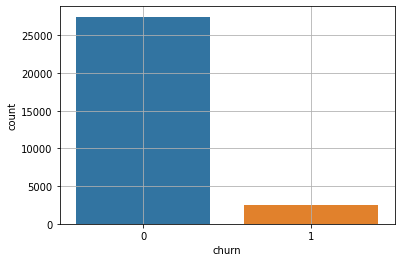

In [ ]:
# barplot of target column
sns.countplot(x='churn', data=df_hv)
plt.grid()
plt.show()

In [ ]:
# There is not a single row with all missing values
df_hv.isnull().all(axis=1).sum()

0

In [ ]:
# All the columns are numeric type
df_hv.dtypes.value_counts()

float64    123
int64       24
dtype: int64

In [ ]:
df_hv.to_csv('clean_data.csv', index=False)

In [ ]:
data = pd.read_csv('clean_data.csv')

In [ ]:
data.shape

(30001, 147)

In [ ]:
missing_data = round((data.isnull().sum() / len(data.index)) * 100)
missing_data[missing_data > 30]

max_rech_data_6     44.0
max_rech_data_7     43.0
max_rech_data_8     47.0
count_rech_2g_6     44.0
count_rech_2g_7     43.0
count_rech_2g_8     47.0
count_rech_3g_6     44.0
count_rech_3g_7     43.0
count_rech_3g_8     47.0
arpu_3g_6           44.0
arpu_3g_7           43.0
arpu_3g_8           47.0
arpu_2g_6           44.0
arpu_2g_7           43.0
arpu_2g_8           47.0
night_pck_user_6    44.0
night_pck_user_7    43.0
night_pck_user_8    47.0
fb_user_6           44.0
fb_user_7           43.0
fb_user_8           47.0
dtype: float64

In [ ]:
# After reading about the dataset found below columns are categorical
cat_cols = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']

# filling missing values with 0 (mode value of the column)
cat_dict = dict.fromkeys(cat_cols, 0)
data.fillna(value=cat_dict, inplace=True)

In [ ]:
missing_data = round((data.isnull().sum() / len(data.index)) * 100)
missing_data[missing_data > 30]

max_rech_data_6    44.0
max_rech_data_7    43.0
max_rech_data_8    47.0
count_rech_2g_6    44.0
count_rech_2g_7    43.0
count_rech_2g_8    47.0
count_rech_3g_6    44.0
count_rech_3g_7    43.0
count_rech_3g_8    47.0
arpu_3g_6          44.0
arpu_3g_7          43.0
arpu_3g_8          47.0
arpu_2g_6          44.0
arpu_2g_7          43.0
arpu_2g_8          47.0
dtype: float64

In [ ]:
#  Train and test split
Y = data.pop('churn')
X = data

In [ ]:
# splitting data into 70% train and 30% test data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=16)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((21000, 146), (9001, 146), (21000,), (9001,))

In [ ]:
# seperating out numerical and categorical dataset
x_train_cat = x_train[cat_cols]
x_train_num = x_train.drop(cat_cols, axis=1)

In [ ]:
x_train_cat.shape, x_train_num.shape

((21000, 6), (21000, 140))

In [ ]:
# Onehot encoding of categorical feaures
cat_ohe = OneHotEncoder()
cat_ohe.fit(x_train_cat)
x_train_cat_ohe = cat_ohe.transform(x_train_cat)
x_train_cat_ohe.shape

(21000, 12)

In [ ]:
# by checking all the numerical columns
# we can see there are group of columns giving specific information
# So, instead of doing EDA on whole dataset
# we can break this data into different smaller group
list(x_train_num.columns)

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t

# EDA

In [ ]:
# Adding target column into data for doing EDA.
# Will remove this column after checking columns
x_train_num['churn'] = y_train

In [ ]:
# Recharge dataset
# This group have total 19 columns
rech_cols = x_train_num.columns[x_train_num.columns.str.contains('rech')]
rech_cols.shape

(19,)

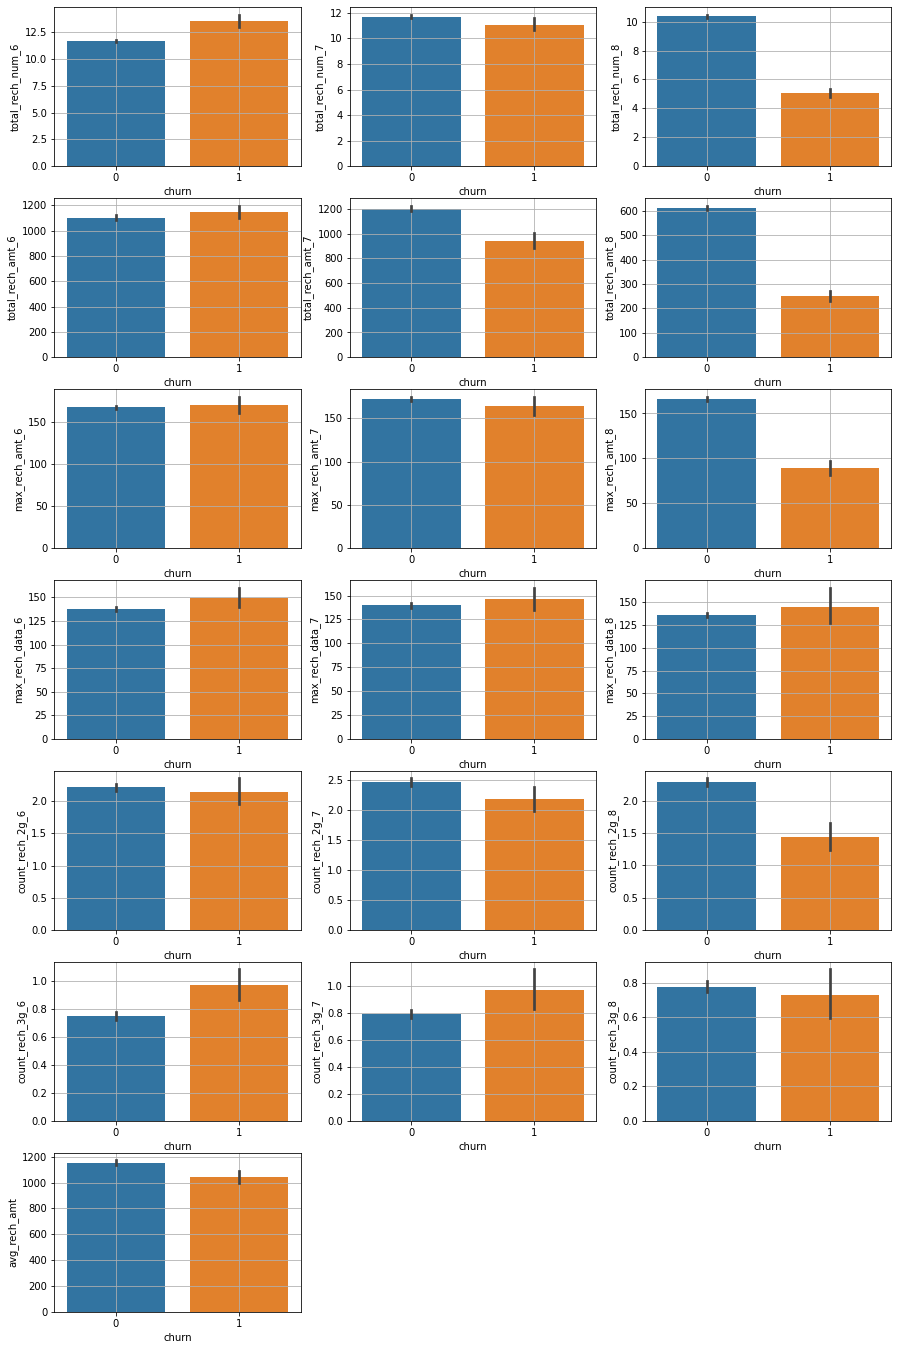

In [ ]:
plt.figure(figsize=(15, 24))
for i in range(19):
    plt.subplot(7, 3, i+1)
    sns.barplot(x='churn', y=rech_cols[i], data=x_train_num)
    plt.grid()

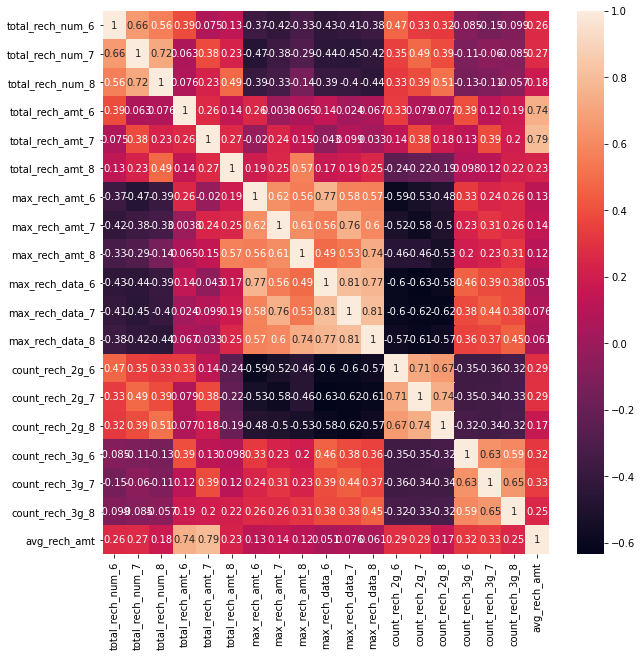

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(x_train_num[rech_cols].corr(), annot=True)
plt.show()

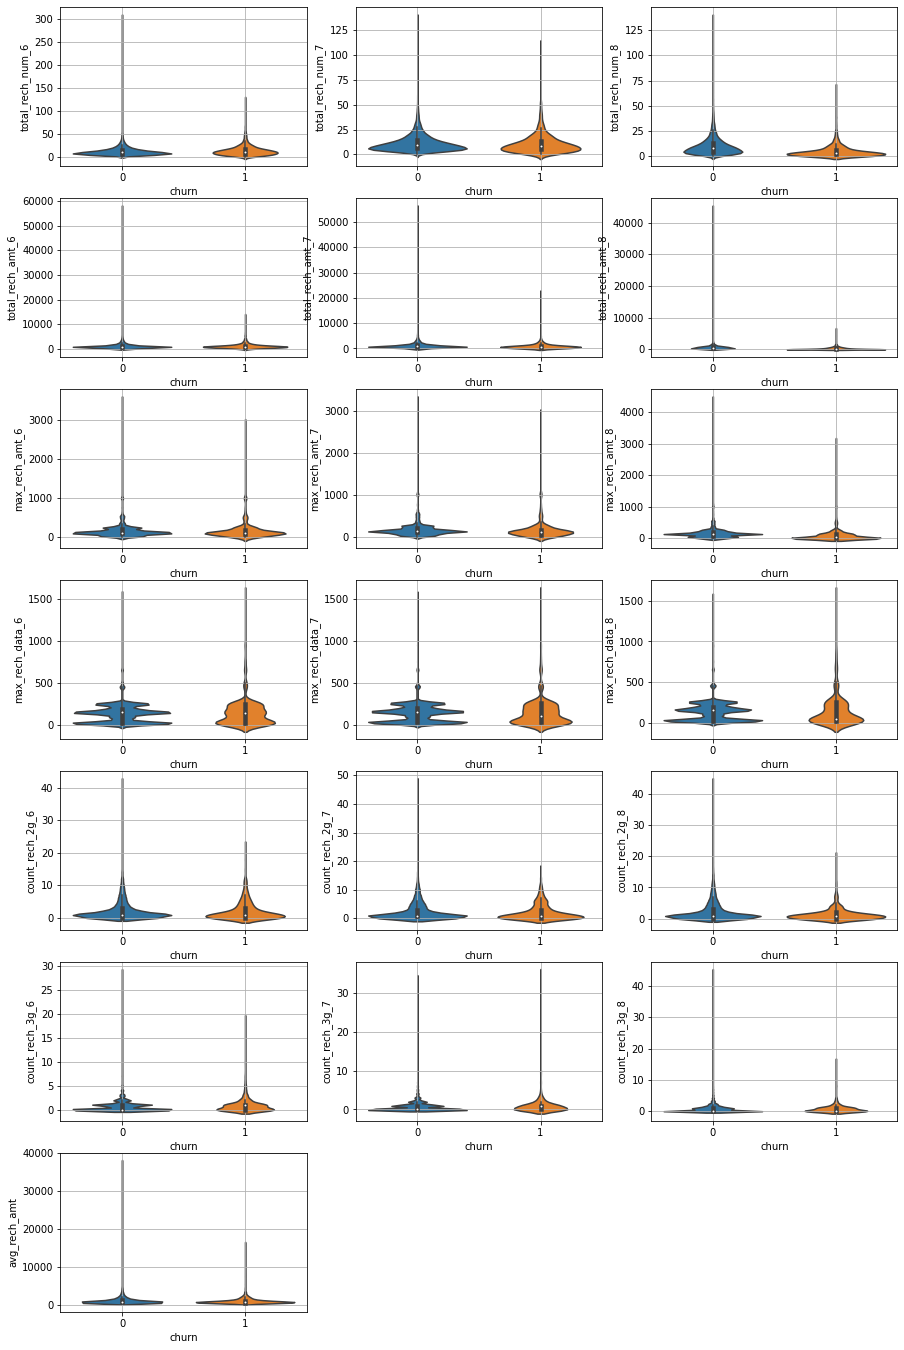

In [ ]:
plt.figure(figsize=(15, 24))
for i in range(19):
    plt.subplot(7, 3, i+1)
    sns.violinplot(x='churn', y=rech_cols[i], data=x_train_num)
    plt.grid()

In [ ]:
for col in rech_cols:
    th = x_train_num[col].quantile(0.9)
    x_train_num.loc[x_train_num[col]>th, col] = th
    x_test.loc[x_test[col]>th, col] = th

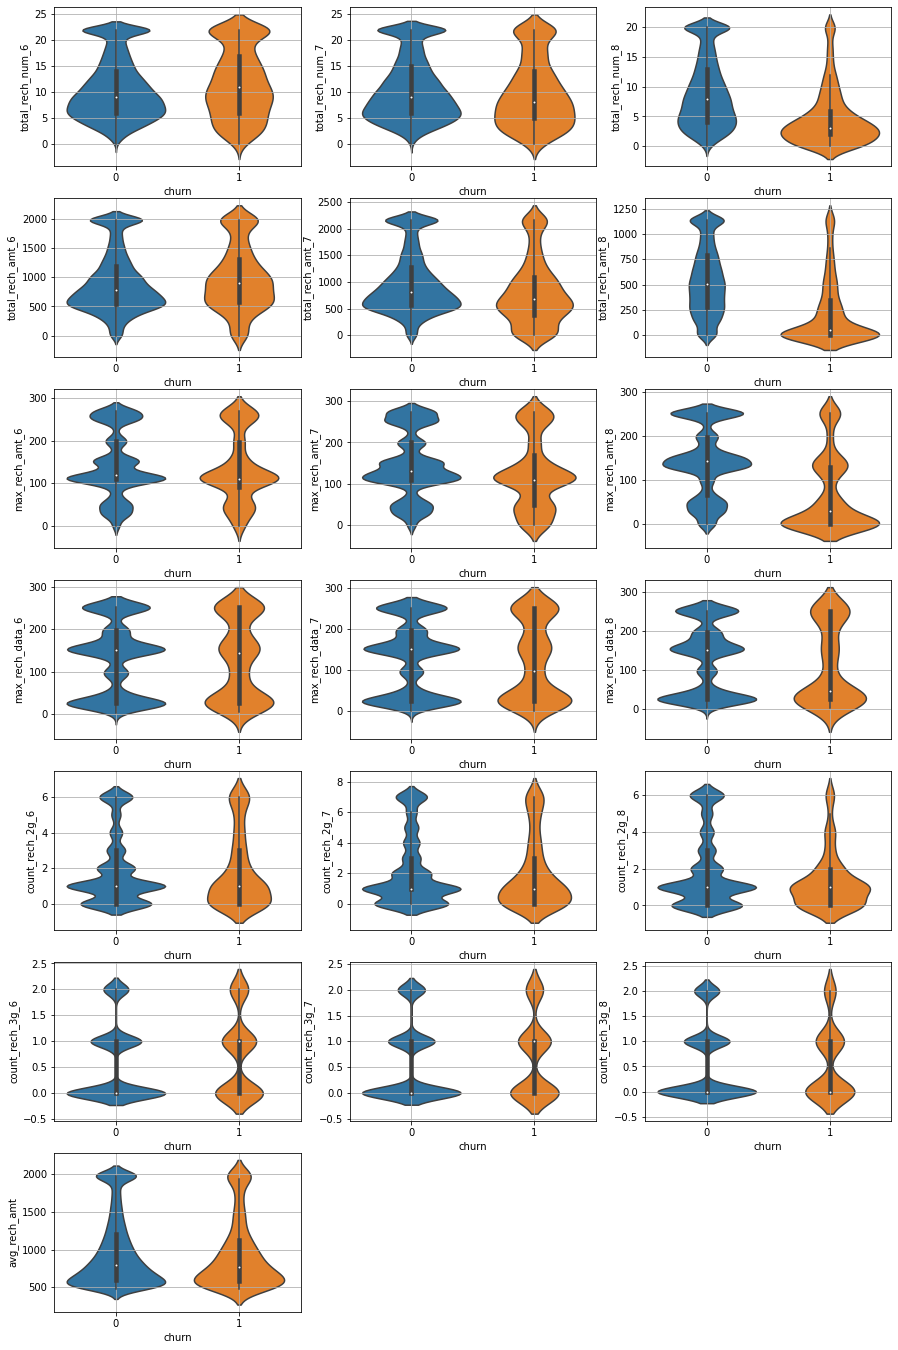

In [ ]:
plt.figure(figsize=(15, 24))
for i in range(19):
    plt.subplot(7, 3, i+1)
    sns.violinplot(x='churn', y=rech_cols[i], data=x_train_num)
    plt.grid()

In [ ]:
# columns with 'amt' keyword
amt_cols = x_train_num.columns[x_train_num.columns.str.contains('amt')]
amt_cols.shape, amt_cols

((10,), Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
        'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
        'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8',
        'avg_rech_amt'],
       dtype='object'))

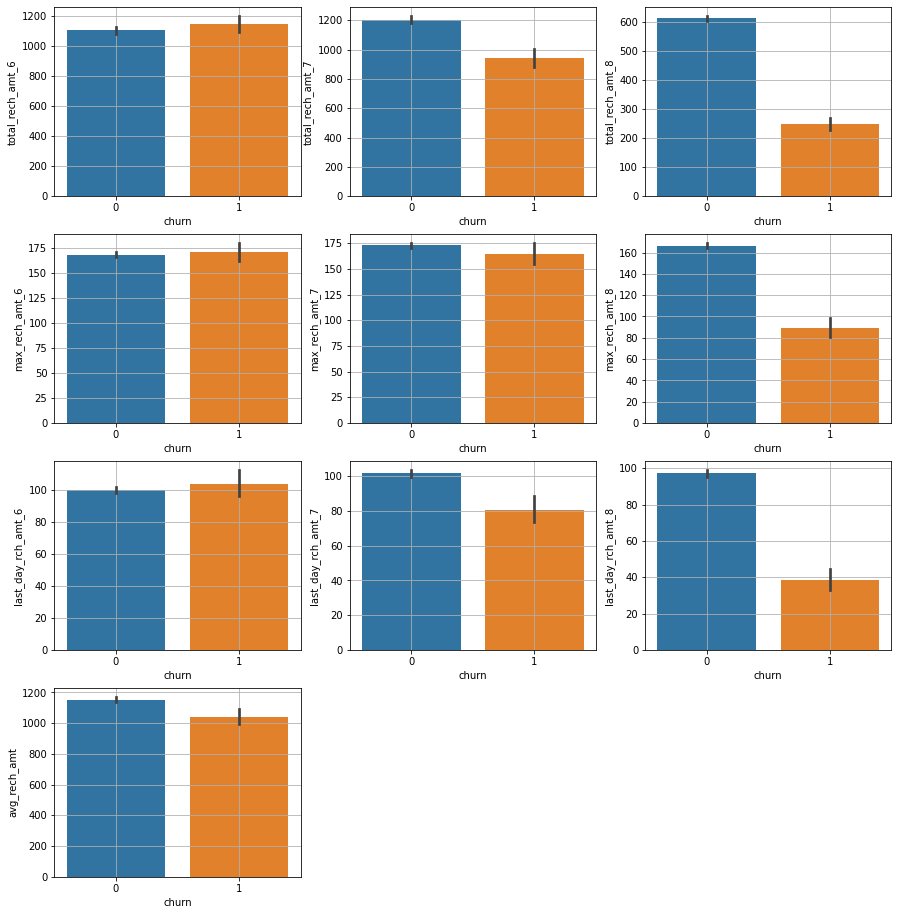

In [ ]:
plt.figure(figsize=(15, 16))
for i in range(10):
    plt.subplot(4, 3, i+1)
    sns.barplot(x='churn', y=amt_cols[i], data=x_train_num)
    plt.grid()

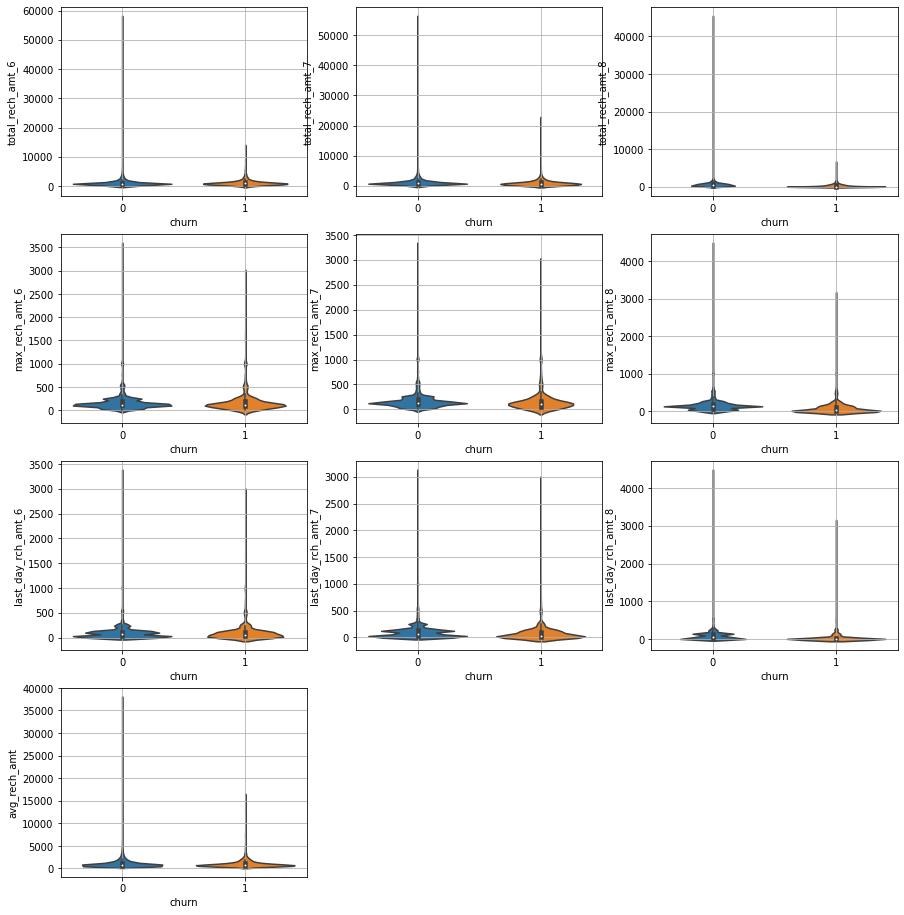

In [ ]:
plt.figure(figsize=(15, 16))
for i in range(10):
    plt.subplot(4, 3, i+1)
    sns.violinplot(x='churn', y=amt_cols[i], data=x_train_num)
    plt.grid()

In [ ]:
for col in amt_cols:
    th = x_train_num[col].quantile(0.9)
    x_train_num.loc[x_train_num[col]>th, col] = th
    x_test.loc[x_test[col]>th, col] = th

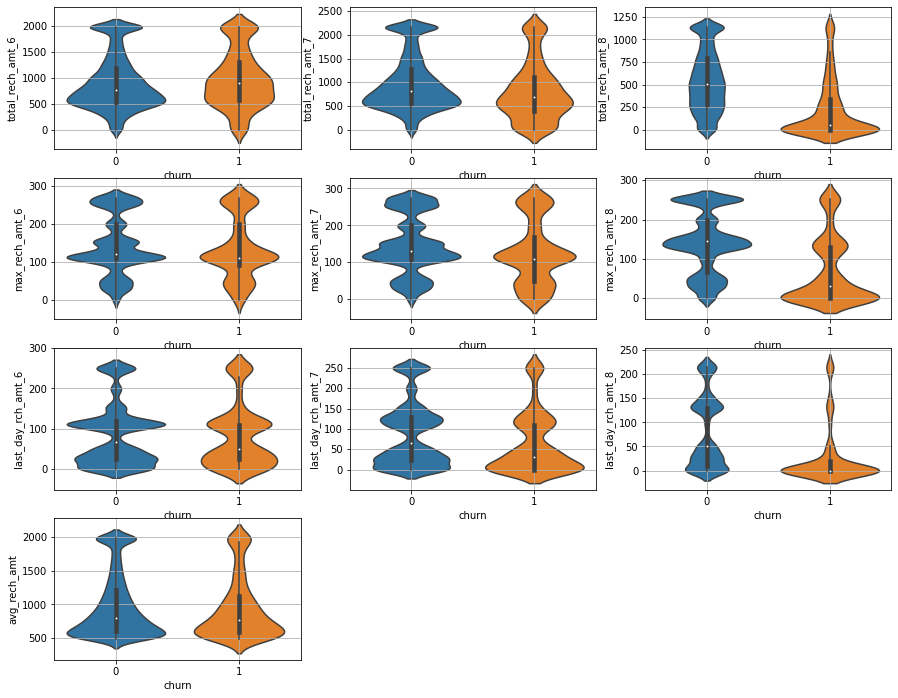

In [ ]:
plt.figure(figsize=(15, 12))
for i in range(10):
    plt.subplot(4, 3, i+1)
    sns.violinplot(x='churn', y=amt_cols[i], data=x_train_num)
    plt.grid()

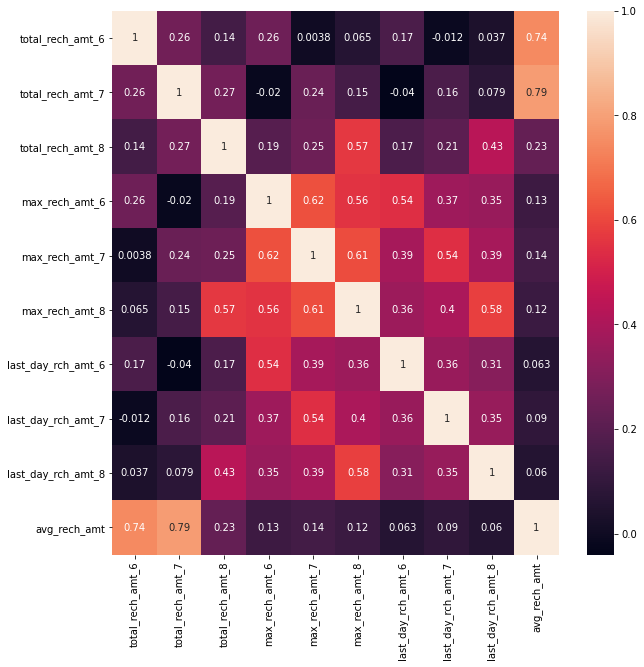

In [ ]:
#amt_data.drop(columns='churn', inplace=True)
plt.figure(figsize=(10, 10))
sns.heatmap(x_train_num[amt_cols].corr(), annot=True)

Only average recharge amount is having high corr with tol_6 and tol_7 thats because we derive that feature from those 2.

In [ ]:
tot_cols = x_train_num.columns[x_train_num.columns.str.contains('tot', regex=True)]
tot_cols.shape, tot_cols

((12,),
 Index(['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_6',
        'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_num_6',
        'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
        'total_rech_amt_7', 'total_rech_amt_8'],
       dtype='object'))

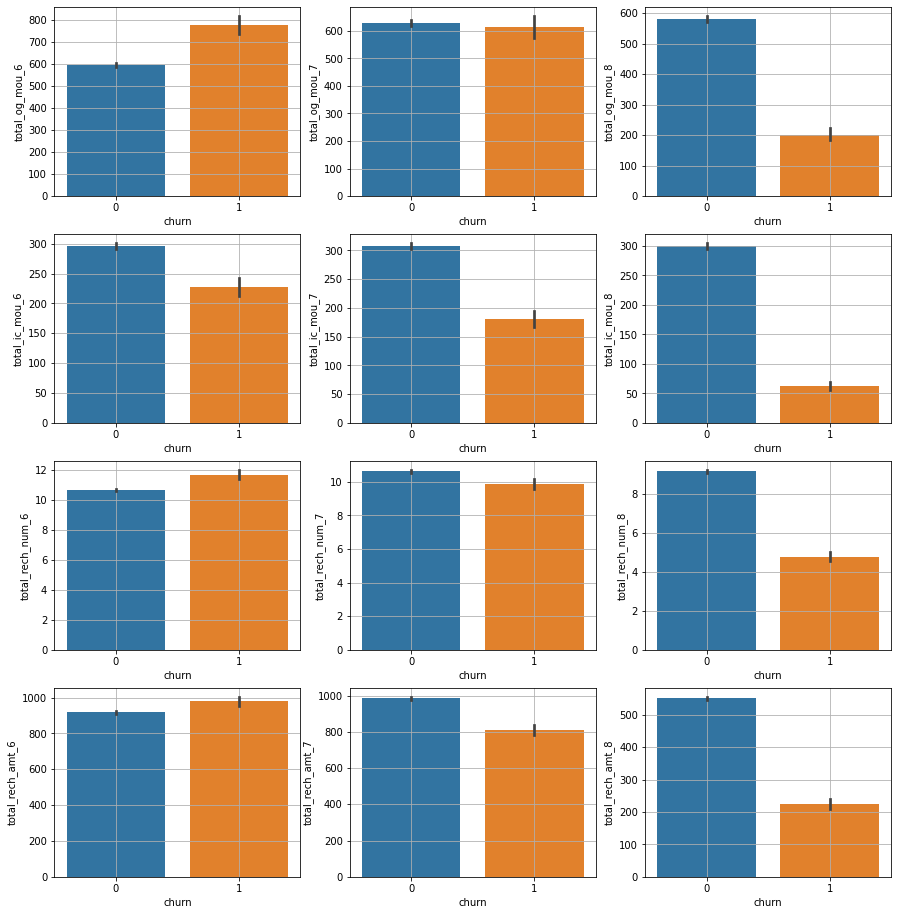

In [ ]:
plt.figure(figsize=(15, 16))
for i in range(12):
    plt.subplot(4, 3, i+1)
    sns.barplot(x='churn', y=tot_cols[i], data=x_train_num)
    plt.grid()
plt.show()

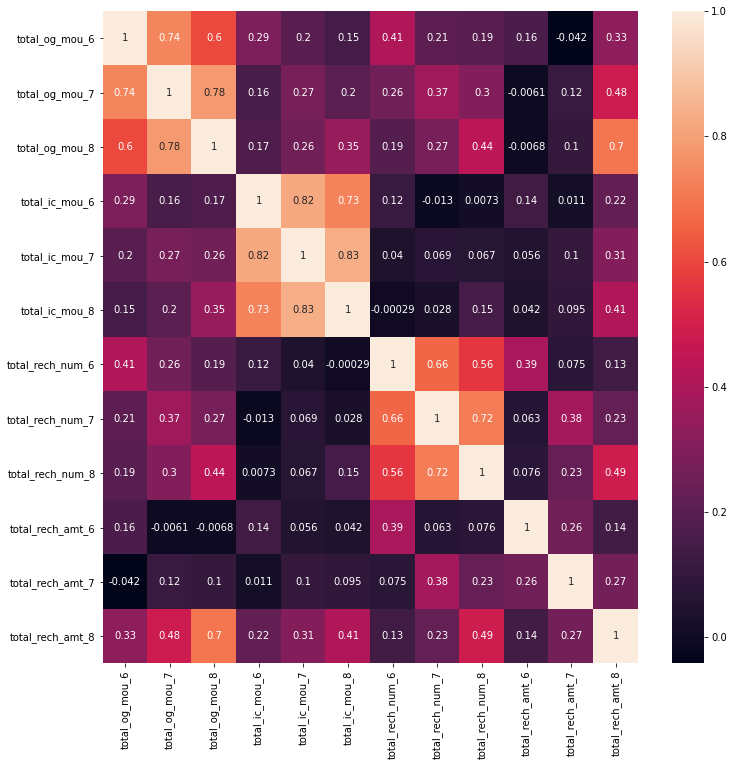

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(x_train_num[tot_cols].corr(), annot=True)
plt.show()

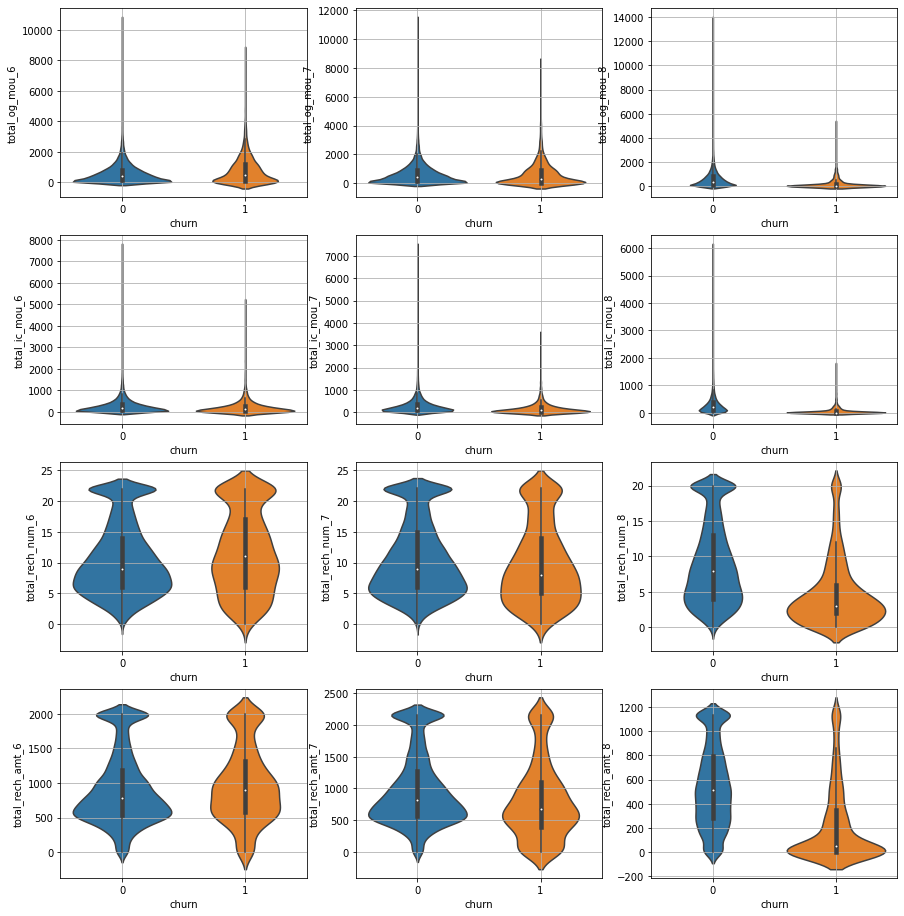

In [ ]:
plt.figure(figsize=(15, 16))
for i in range(12):
    plt.subplot(4, 3, i+1)
    sns.violinplot(x='churn', y=tot_cols[i], data=x_train_num)
    plt.grid()
plt.show()

In [ ]:
for col in tot_cols[:6]:
    th = x_train_num[col].quantile(0.9)
    x_train_num.loc[x_train_num[col]>th, col] = th
    x_test.loc[x_test[col]>th, col] = th

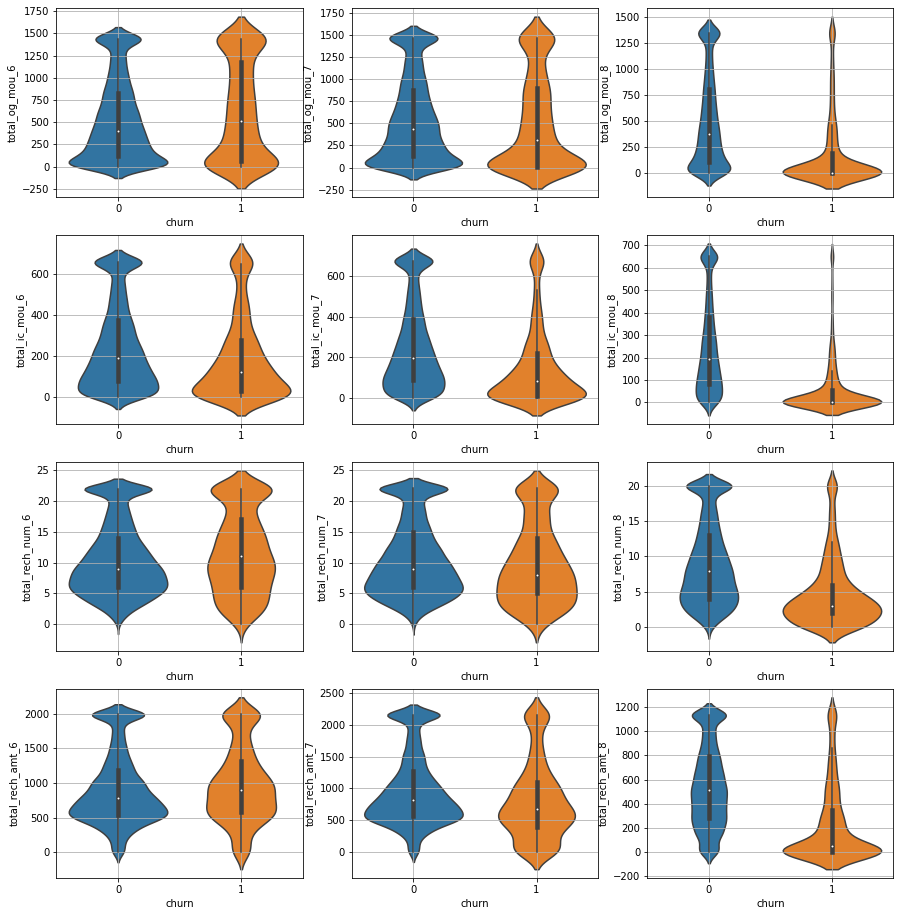

In [ ]:
plt.figure(figsize=(15, 16))
for i in range(12):
    plt.subplot(4, 3, i+1)
    sns.violinplot(x='churn', y=tot_cols[i], data=x_train_num)
    plt.grid()
plt.show()

In [ ]:
ic_cols = x_train_num.columns[x_train_num.columns.str.contains('ic_.*mou', regex=True)]
ic_cols, ic_cols.shape

(Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'loc_ic_t2t_mou_6',
        'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6',
        'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6',
        'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7',
        'loc_ic_mou_8', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7',
        'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7',
        'std_ic_t2m_mou_8', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7',
        'std_ic_t2f_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8',
        'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_6',
        'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7',
        'isd_ic_mou_8'],
       dtype='object'), (36,))

In [ ]:
x_train_num[ic_cols].describe()

,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8
count,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,21000.000000,21000.000000,21000.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000
mean,16.130710,13.073280,12.928435,65.951990,67.206694,64.638244,153.852113,155.052134,152.263752,15.319834,16.270605,14.960408,235.133769,238.539279,231.872172,15.249828,15.777038,14.254224,29.980060,31.605943,29.365176,2.827658,2.895907,2.748489,48.061165,50.282589,46.371405,244.502309,250.318015,235.102203,0.062948,0.020279,0.027424,11.056327,11.890801,11.381008
std,74.092907,78.286269,77.619385,161.375072,166.699771,159.705689,224.893515,221.379762,217.196515,44.067110,50.337534,43.698587,317.236088,317.496026,308.116605,81.754170,88.344982,70.077076,101.295354,107.544467,106.741824,19.147069,19.965375,19.969032,142.581269,153.145908,141.152696,208.698809,211.835321,208.547758,0.203643,0.151795,0.107629,82.420282,85.014143,71.251470
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,6.830000,7.490000,6.360000,31.060000,33.555000,29.932500,0.000000,0.000000,0.000000,51.440000,56.677500,49.295000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.330000,1.330000,0.860000,73.137500,79.205000,62.637500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,25.960000,26.580000,24.710000,87.130000,87.890000,86.015000,2.040000,2.130000,2.080000,138.840000,141.735000,137.385000,0.460000,0.510000,0.280000,5.310000,5.590000,4.460000,0.000000,0.000000,0.000000,12.010000,12.820000,10.630000,184.200000,187.730000,173.510000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,68.240000,69.640000,67.540000,191.930000,194.502500,191.675000,12.130000,12.490000,12.090000,301.110000,301.877500,295.152500,8.480000,8.790000,7.540000,24.390000,25.610000,22.780000,0.160000,0.250000,0.230000,42.740000,44.660000,40.140000,370.105000,377.440000,361.407500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2613.310000,3813.290000,4169.810000,4363.960000,5709.590000,3971.940000,4693.860000,4171.510000,4643.490000,1373.090000,1983.010000,1459.690000,7454.630000,6466.740000,5305.140000,5459.560000,5800.930000,4309.290000,4630.230000,3470.380000,5645.860000,1069.980000,1136.080000,1201.180000,5459.630000,6745.760000,5957.140000,659.881000,673.952000,649.670000,19.760000,13.460000,1.260000,6789.410000,4747.910000,3432.880000


In [ ]:
tmp_cols = x_train_num[ic_cols][x_train_num[ic_cols]<1].count(axis=0) / len(x_train_num)

In [ ]:
ic_cols_drop = tmp_cols[tmp_cols >= 0.75].index

In [ ]:
ic_cols_drop

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'std_ic_t2f_mou_6',
       'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7',
       'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8'],
      dtype='object')

In [ ]:
x_train_num.drop(ic_cols_drop, axis=1, inplace=True)

In [ ]:
ic_cols = x_train_num.columns[x_train_num.columns.str.contains('ic_.*mou', regex=True)]
ic_cols, ic_cols.shape

(Index(['loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8',
        'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
        'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8',
        'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_t2t_mou_6',
        'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6',
        'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_mou_6', 'std_ic_mou_7',
        'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8'],
       dtype='object'), (24,))

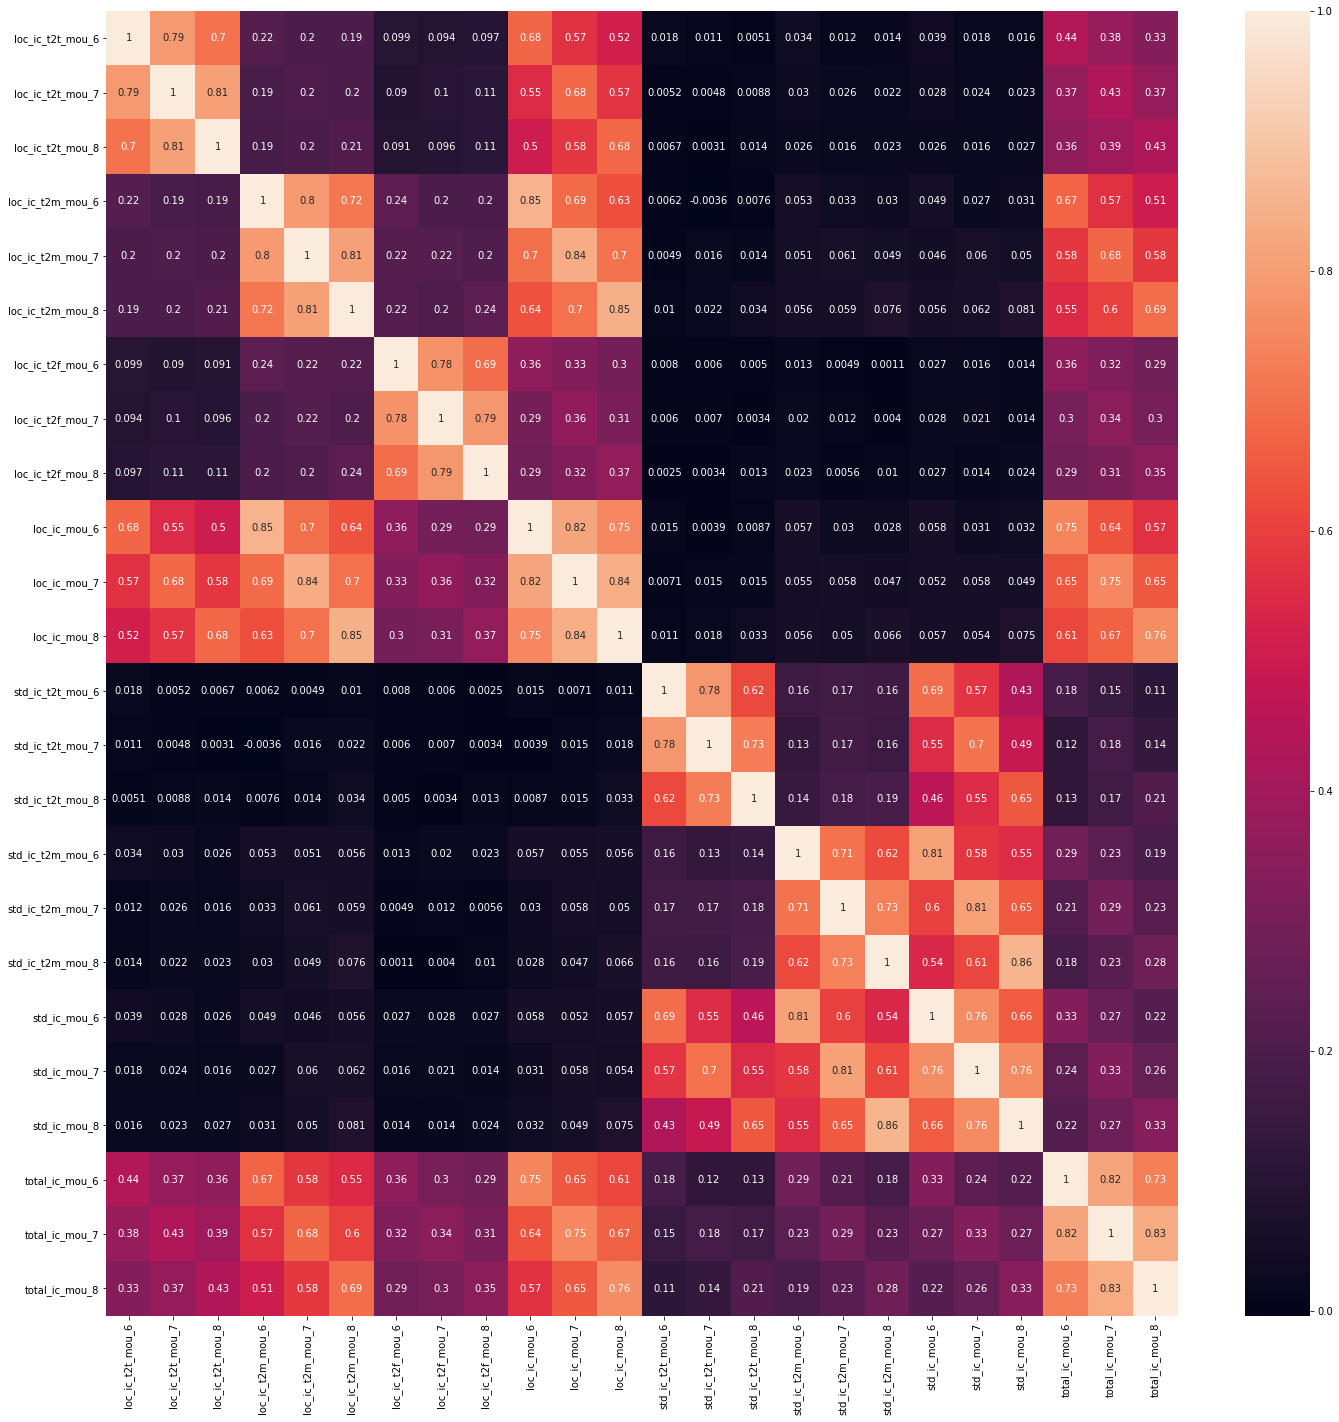

In [ ]:
plt.figure(figsize=(24, 24))
sns.heatmap(x_train_num[ic_cols].corr(), annot=True)
plt.show()

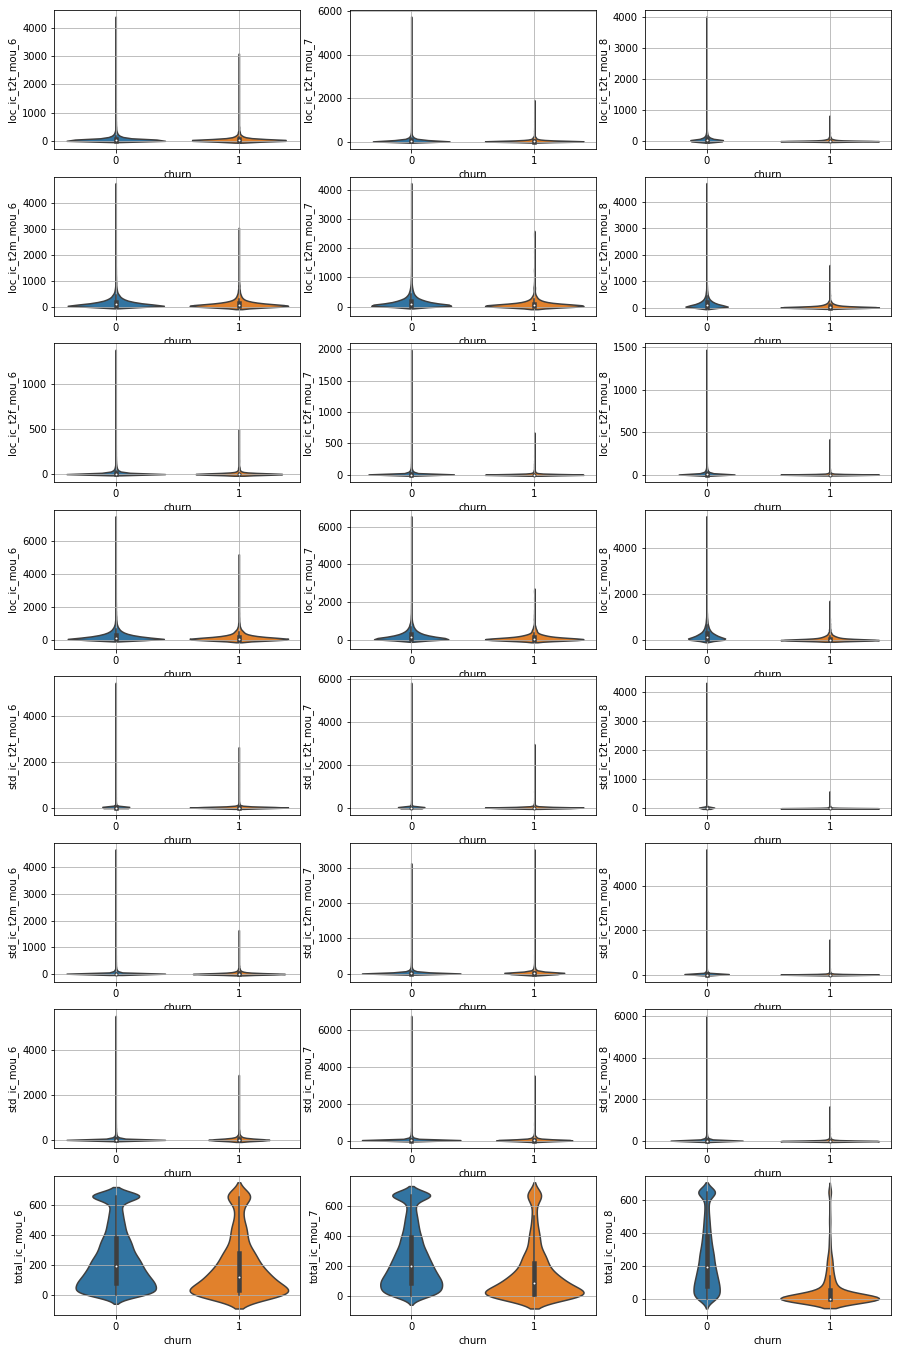

In [ ]:
plt.figure(figsize=(15, 24))
for i in range(24):
    plt.subplot(8, 3, i+1)
    sns.violinplot(x='churn', y=ic_cols[i], data=x_train_num)
    plt.grid()
plt.show()

In [ ]:
for col in ic_cols:
    th = x_train_num[col].quantile(0.9)
    x_train_num.loc[x_train_num[col]>th, col] = th
    x_test.loc[x_test[col]>th, col] = th

In [ ]:
og_cols = x_train_num.columns[x_train_num.columns.str.contains('og_.*mou', regex=True)]
og_cols, og_cols.shape

(Index(['roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
        'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
        'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
        'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
        'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
        'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
        'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
        'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
        'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
        'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
        'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6', 'total_og_mou_7',
        'total_og_mou_8'],
       dtype='object'), (39,))

In [ ]:
x_train_num[og_cols].describe()

,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,total_og_mou_6,total_og_mou_7,total_og_mou_8
count,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000,21000.000000,21000.000000,21000.000000
mean,26.560035,20.921473,20.658710,86.625880,87.684675,81.296643,166.483173,166.830752,158.537747,6.522843,6.636145,6.215501,1.603240,1.903056,1.752843,259.640309,261.160107,246.058095,166.464011,174.641056,151.647773,183.115562,190.594147,162.967946,1.864659,1.888980,1.731518,351.448012,367.127964,316.350726,2.046791,2.062203,1.991237,5.891091,7.281539,6.795713,534.416171,548.817864,471.787681
std,113.248602,99.066150,108.581648,236.058746,248.360353,237.822278,250.194910,246.105230,238.136818,23.328813,22.907121,20.576682,6.060952,8.546440,7.194860,384.319265,384.022763,372.194764,407.278106,424.219641,403.274674,412.279925,430.143810,405.689468,12.703470,13.648298,11.657025,612.417482,639.661034,608.232906,33.338055,37.066937,35.040562,16.706319,21.435631,19.748899,472.844516,484.330203,449.236459
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,5.090000,5.460000,3.860000,21.410000,23.525000,17.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.340000,38.637500,29.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.510000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,117.895000,118.312500,74.855000
50%,0.000000,0.000000,0.000000,25.460000,25.590000,23.090000,80.980000,81.375000,74.250000,0.110000,0.210000,0.020000,0.000000,0.000000,0.000000,130.110000,131.935000,120.870000,3.290000,3.230000,1.400000,18.160000,18.300000,12.340000,0.000000,0.000000,0.000000,49.330000,50.435000,32.910000,0.000000,0.000000,0.000000,0.310000,0.830000,0.680000,405.510000,425.925000,337.085000
75%,0.000000,0.000000,0.000000,80.140000,80.482500,76.752500,211.940000,211.815000,207.037500,4.440000,4.540000,4.310000,0.010000,0.130000,0.100000,335.780000,340.292500,324.287500,112.780000,118.202500,83.580000,161.590000,168.245000,128.745000,0.000000,0.000000,0.000000,476.440000,509.020000,378.905000,0.000000,0.000000,0.000000,5.440000,7.210000,6.630000,854.902500,884.695000,772.275000
max,3775.110000,2812.040000,5337.040000,6431.330000,7400.660000,10752.560000,4696.830000,4456.740000,4524.590000,1466.030000,1196.430000,928.490000,182.730000,458.760000,351.830000,10643.380000,7674.780000,11039.910000,7366.580000,8133.660000,8014.430000,8314.760000,9284.740000,13411.210000,628.560000,544.630000,516.910000,8432.990000,10936.730000,13668.780000,3229.290000,3868.010000,3629.910000,537.880000,1125.310000,549.140000,1441.375000,1471.363000,1347.467000


In [ ]:
tmp = x_train_num[og_cols][x_train_num[og_cols] <=1].count(axis=0) / len(x_train_num)

In [ ]:
og_drop = tmp[tmp >= 0.75]

In [ ]:
og_drop

roam_og_mou_6       0.780905
roam_og_mou_7       0.816429
roam_og_mou_8       0.794952
loc_og_t2c_mou_6    0.795143
loc_og_t2c_mou_7    0.784857
loc_og_t2c_mou_8    0.775762
std_og_t2f_mou_6    0.863571
std_og_t2f_mou_7    0.867762
std_og_t2f_mou_8    0.851286
isd_og_mou_6        0.934333
isd_og_mou_7        0.937095
isd_og_mou_8        0.923143
dtype: float64

In [ ]:
# drop
x_train_num.drop(columns=og_drop.index, inplace=True)

In [ ]:
og_cols = x_train_num.columns[x_train_num.columns.str.contains('og_.*mou', regex=True)]
og_cols, og_cols.shape

(Index(['loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
        'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
        'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
        'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
        'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
        'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_mou_6', 'std_og_mou_7',
        'std_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8',
        'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8'],
       dtype='object'), (27,))

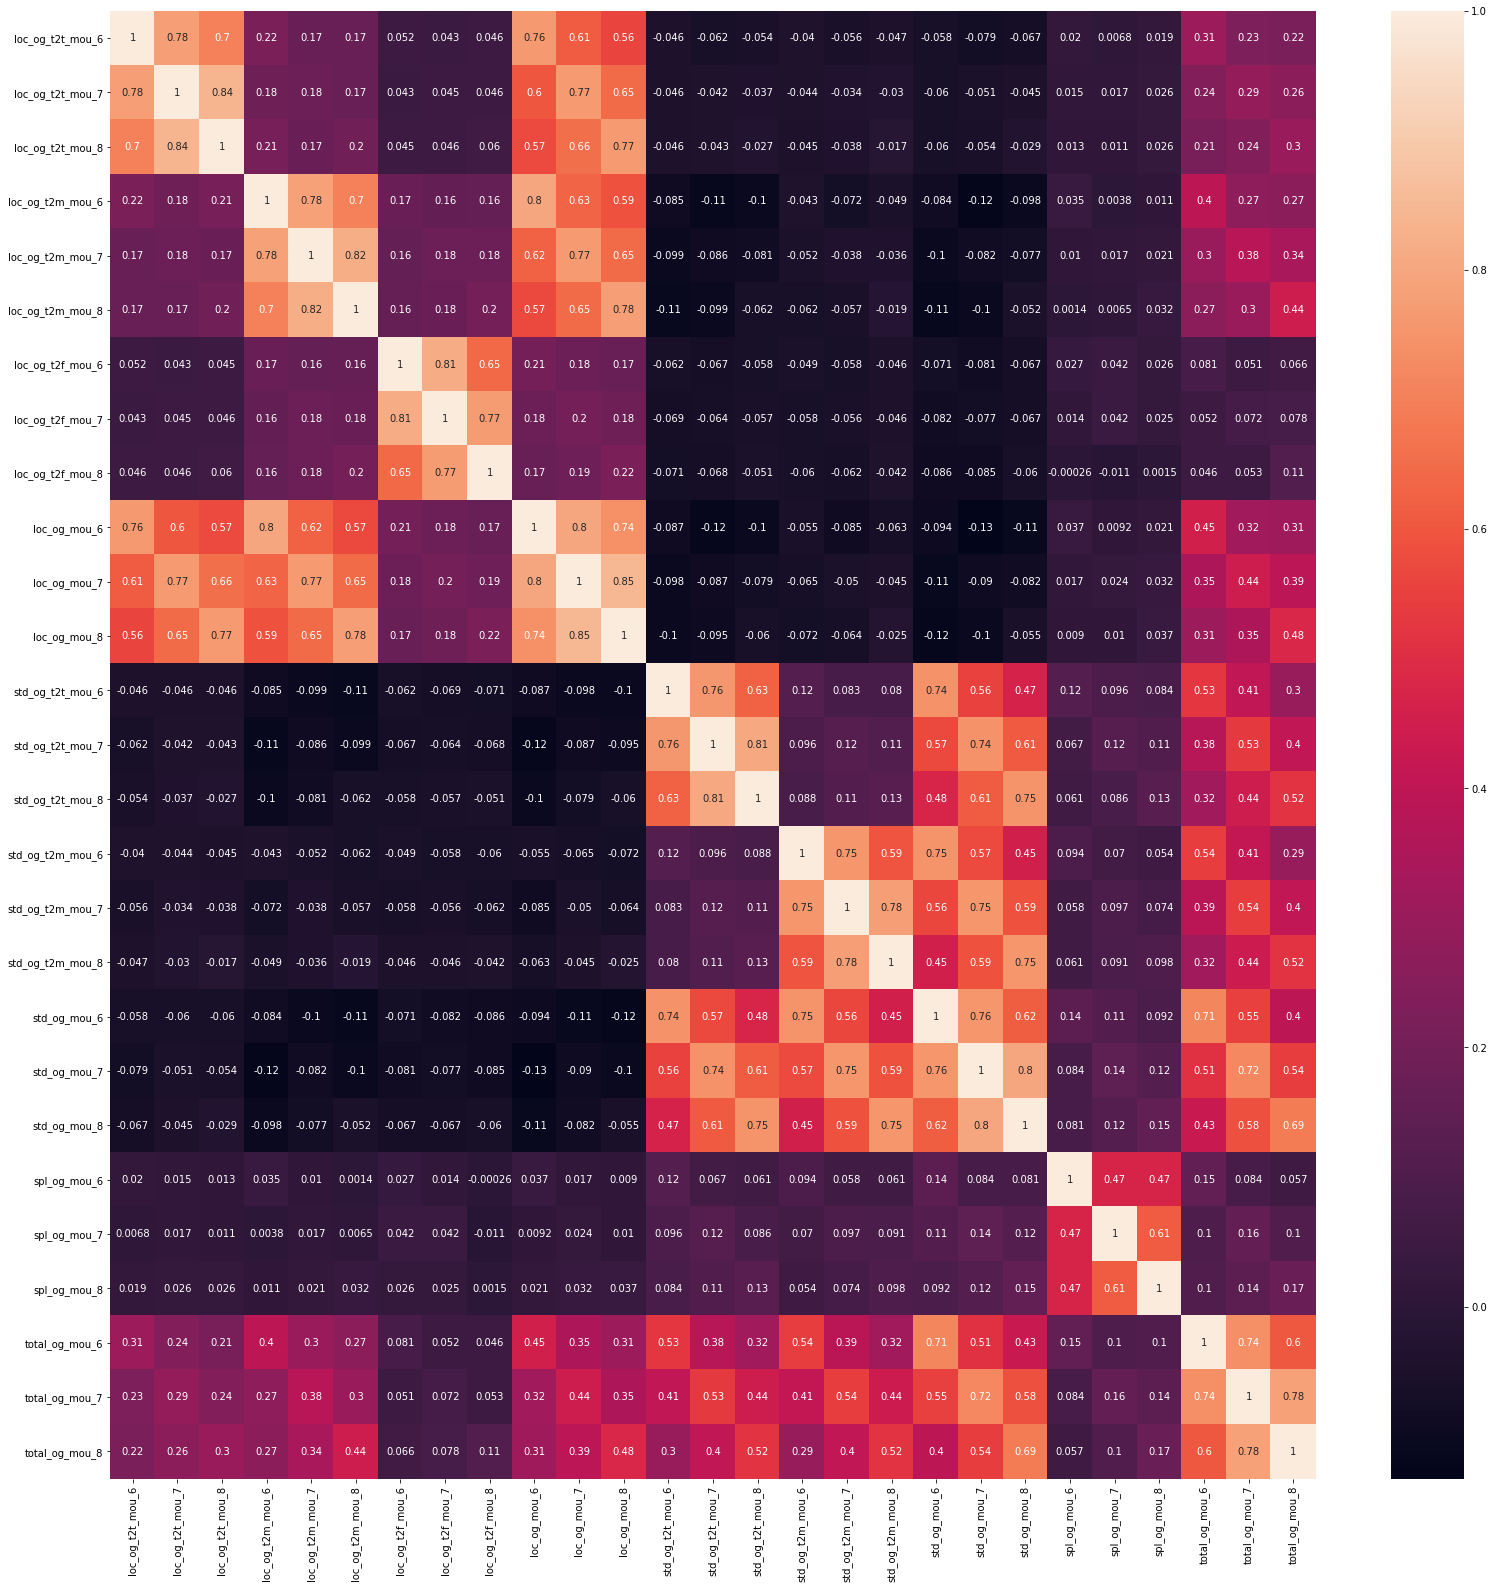

In [ ]:
plt.figure(figsize=(27, 27))
sns.heatmap(x_train_num[og_cols].corr(), annot=True)
plt.show()

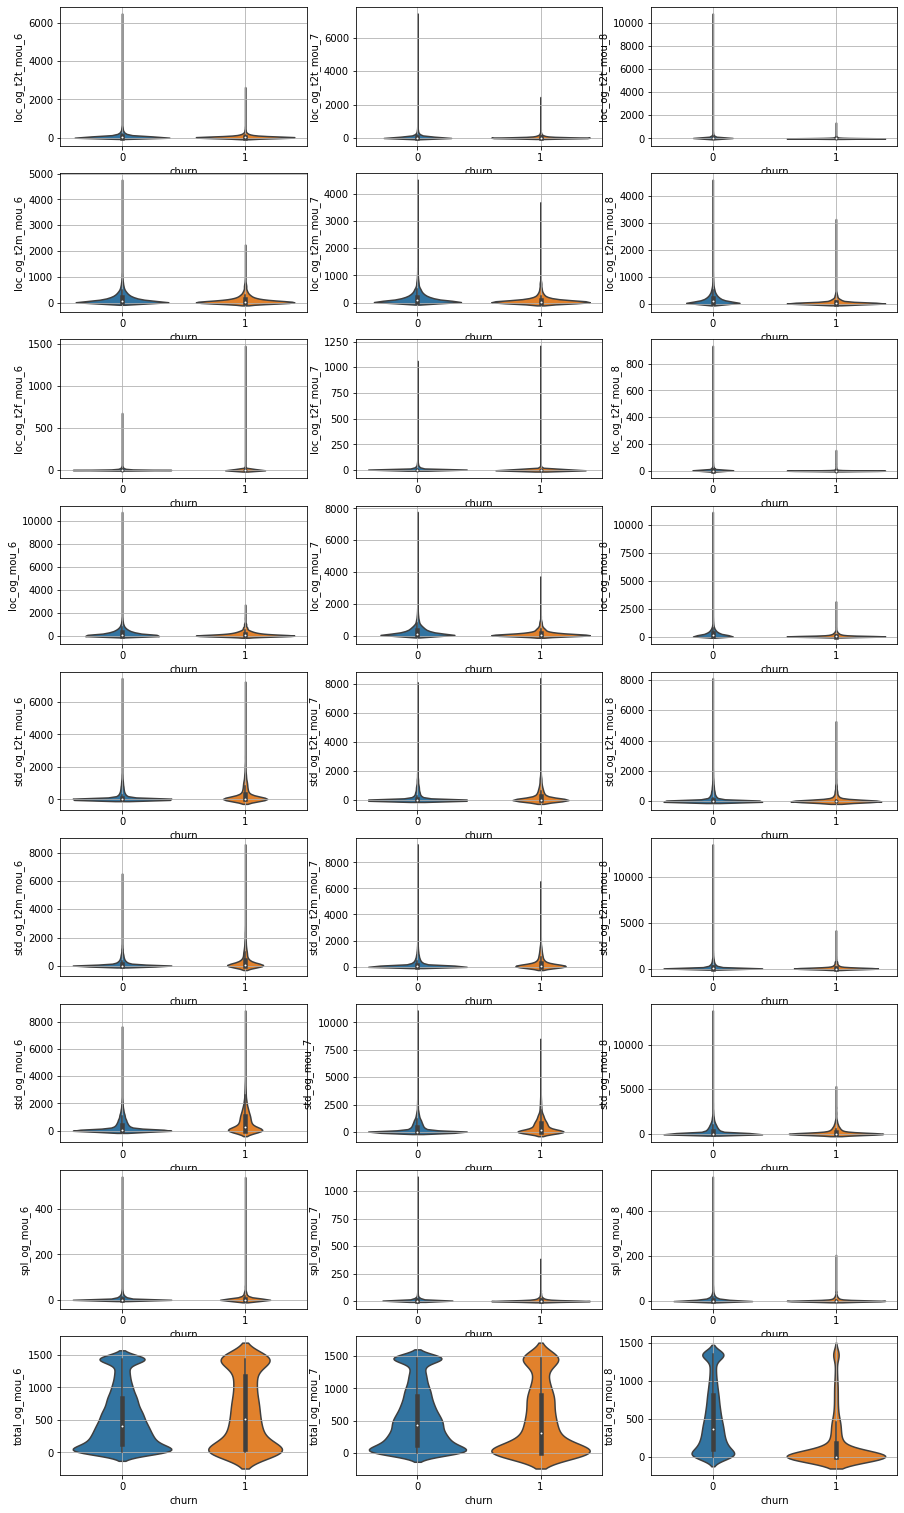

In [ ]:
plt.figure(figsize=(15, 27))
for i in range(27):
    plt.subplot(9, 3, i+1)
    sns.violinplot(x='churn', y=og_cols[i], data=x_train_num)
    plt.grid()
plt.show()

In [ ]:
for col in og_cols[:-3]:
    th = x_train_num[col].quantile(0.9)
    x_train_num.loc[x_train_num[col]>th, col] = th
    x_test.loc[x_test[col]>th, col] = th

In [ ]:
net_mou = x_train.columns[x_train.columns.str.contains('net_mou')]
net_mou.shape, net_mou

((6,), Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
        'offnet_mou_7', 'offnet_mou_8'],
       dtype='object'))

In [ ]:
x_train_num[net_mou].describe()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8
count,20621.000000,20632.000000,20198.000000,20621.000000,20632.000000,20198.000000
mean,263.632786,270.552465,241.053872,380.741946,385.481457,348.486689
std,465.193617,486.298917,468.706448,483.436118,497.495072,478.112233
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.030000,17.930000,14.110000,79.680000,77.487500,59.537500
50%,87.540000,86.185000,72.490000,230.240000,228.690000,198.975000
75%,292.710000,292.727500,249.175000,493.240000,500.977500,455.857500
max,7376.710000,8157.780000,10752.560000,8362.360000,9667.130000,13547.840000


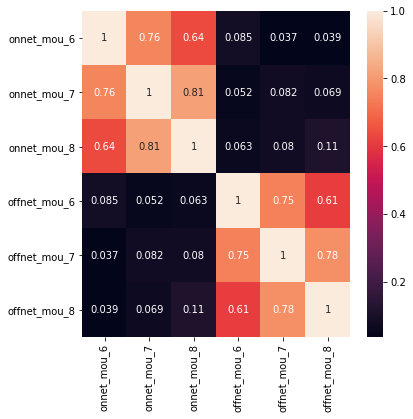

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(x_train_num[net_mou].corr(), annot=True)
plt.show()

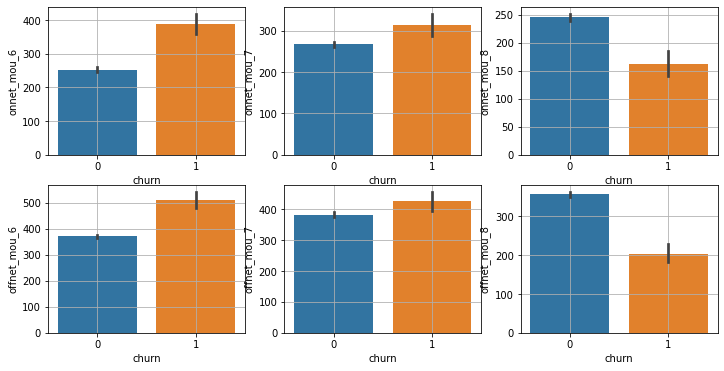

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    sns.barplot(x='churn', y=net_mou[i], data=x_train_num)
    plt.grid()
plt.show()

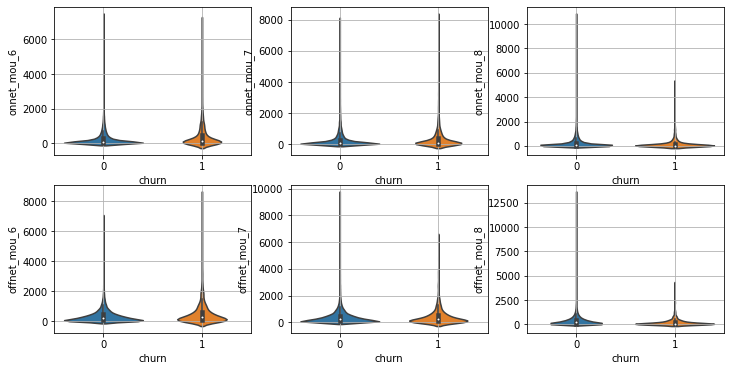

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    sns.violinplot(x='churn', y=net_mou[i], data=x_train_num)
    plt.grid()
plt.show()

In [ ]:
for col in net_mou:
    th = x_train_num[col].quantile(0.9)
    x_train_num.loc[x_train_num[col]>th, col] = th
    x_test.loc[x_test[col]>th, col] = th

In [ ]:
g3_cols = x_train.columns[x_train.columns.str.contains('3g')]
g3_cols.shape, g3_cols

((18,),
 Index(['count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'vol_3g_mb_6',
        'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
        'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
        'sachet_3g_7', 'sachet_3g_8', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
       dtype='object'))

In [ ]:
x_train_num[g3_cols].describe()

,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,11788.000000,11979.000000,11152.000000,21000.000000,21000.000000,21000.000000,11788.000000,11979.000000,11152.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,0.586698,0.590450,0.565818,341.049956,367.420543,350.225029,118.037323,120.328146,117.485997,0.218190,0.228952,0.210762,0.211619,0.227286,0.202048,169.020873,177.818305,158.332205
std,0.731225,0.747498,0.735100,894.414740,897.258059,917.104594,217.393833,225.337197,219.226590,0.612669,0.651870,0.620044,1.008171,1.116188,1.116136,418.118726,438.141791,410.457355
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-30.280000,-26.040000,-24.490000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.500000,12.900000,10.755000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,356.562500,403.800000,349.667500,173.110000,180.310000,178.897500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,127.870000,133.432500,98.967500
max,2.000000,2.000000,2.000000,45735.400000,27600.290000,30036.060000,5054.370000,3726.750000,3483.620000,14.000000,14.000000,16.000000,29.000000,35.000000,41.000000,7570.830000,9165.600000,7581.250000


In [ ]:
tmp = x_train_num[g3_cols][x_train_num[g3_cols]==0].count(axis=0) / len(x_train_num)
g3_drop = tmp[tmp >= 0.75]
g3_drop

In [ ]:
x_train_num.drop(columns=g3_drop.index, inplace=True)

In [ ]:
g3_cols = x_train_num.columns[x_train_num.columns.str.contains('3g')]
g3_cols.shape, g3_cols

((12,),
 Index(['count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'vol_3g_mb_6',
        'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
        'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
       dtype='object'))

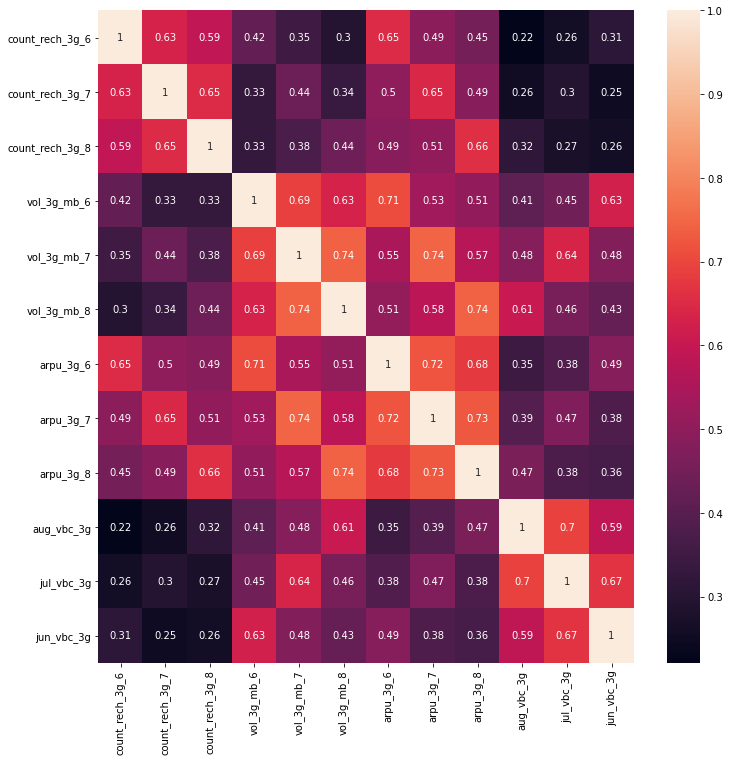

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(x_train_num[g3_cols].corr(), annot=True)
plt.show()

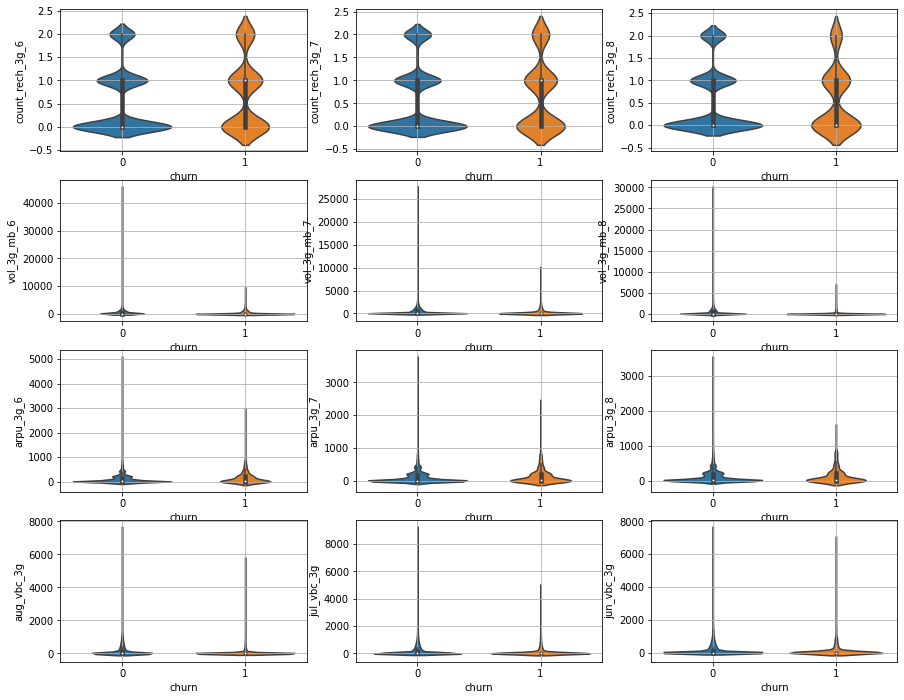

In [ ]:
plt.figure(figsize=(15, 12))
for i in range(12):
    plt.subplot(4, 3, i+1)
    sns.violinplot(x='churn', y=g3_cols[i], data=x_train_num)
    plt.grid()
plt.show()

In [ ]:
for col in g3_cols[3:]:
    th = x_train_num[col].quantile(0.9)
    x_train_num.loc[x_train_num[col]>th, col] = th
    x_test.loc[x_test[col]>th, col] = th

In [ ]:
g2_cols = x_train_num.columns[x_train_num.columns.str.contains('2g')]
g2_cols.shape, g2_cols

((15,),
 Index(['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'vol_2g_mb_6',
        'vol_2g_mb_7', 'vol_2g_mb_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8',
        'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6',
        'sachet_2g_7', 'sachet_2g_8'],
       dtype='object'))

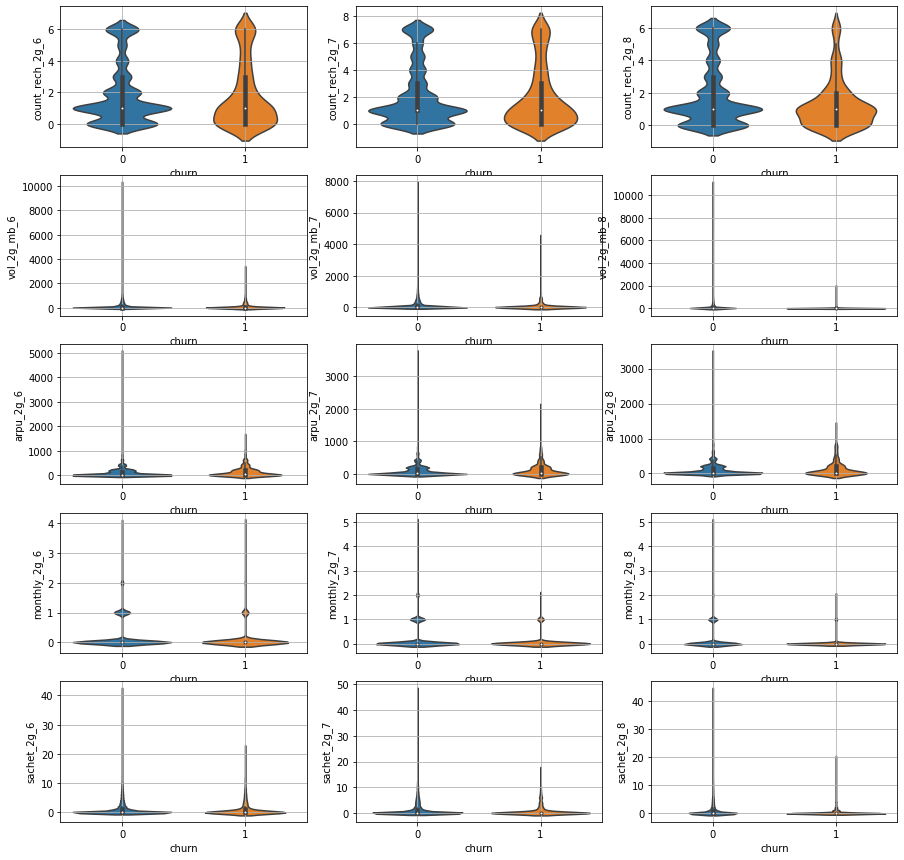

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(15):
    plt.subplot(5, 3, i+1)
    sns.violinplot(x='churn', y=g2_cols[i], data=x_train_num)
    plt.grid()
plt.show()

In [ ]:
for col in g2_cols[3:]:
    th = x_train_num[col].quantile(0.9)
    x_train_num.loc[x_train_num[col]>th, col] = th
    x_test.loc[x_test[col]>th, col] = th

# Data Preparation

In [ ]:
# droping columns from test data which were removed from train data
test_cols_drop = list(ic_cols_drop) + list(og_drop.index) + list(g3_drop.index)

In [ ]:
x_test.drop(test_cols_drop, axis=1, inplace=True)

In [ ]:
# droping 'churn' also, as it was added only for EDA
x_train_num.drop('churn', axis=1, inplace=True)

In [ ]:
x_train_num.shape, x_test.shape

((21000, 110), (9001, 116))

In [ ]:
pickle.dump((x_train_num, x_train_cat, x_test, y_train, y_test), open('data_after_split.pkl', 'wb'))

In [ ]:
x11, x12, x2, y1, y2 = pickle.load(open('data_after_split.pkl', 'rb'))

In [ ]:
# I want to fill Null values with most occuring value of the column
num_fillna = x_train_num.mode().loc[0]

In [ ]:
x_train_num.fillna(num_fillna, inplace=True)

In [ ]:
# Column standardization
scaler = StandardScaler()
x_train_numStd = scaler.fit_transform(x_train_num)
x_train_numStd.shape, type(x_train_numStd)

((21000, 110), numpy.ndarray)

In [ ]:
# combining numerical and categorical data
x_train_std = np.hstack((x_train_numStd, x_train_cat_ohe.toarray()))

In [ ]:
cat_cols

['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']

In [ ]:
# test data
x_test_cat = x_test[cat_cols]
x_test_num = x_test.drop(columns=cat_cols)

In [ ]:
x_test_num.shape, x_test_cat.shape

((9001, 110), (9001, 6))

In [ ]:
x_test_cat_ohe = cat_ohe.transform(x_test_cat)

In [ ]:
x_test_num.fillna(num_fillna, inplace=True)

In [ ]:
x_test_num.isnull().sum().sum()

0

In [ ]:
x_test_num_std = scaler.transform(x_test_num)
x_test_num_std.shape

(9001, 110)

In [ ]:
x_test_std = np.hstack((x_test_num_std, x_test_cat_ohe.toarray()))

(9001, 122)

In [ ]:
x_train_std.shape, x_test_std.shape

((21000, 122), (9001, 122))

In [ ]:
y_train.shape, y_test.shape

((21000,), (9001,))

In [ ]:
# Oversampling
# As the dataset is highly imbalanced
# will use SMOTE oversampling to balance train data
smt = SMOTE(random_state=16)
x_train_smote, y_train_smote = smt.fit_sample(x_train_std, y_train)

In [ ]:
x_train_smote.shape, y_train_smote.shape

((38494, 122), (38494,))

In [ ]:
# Feature Selection
pca = PCA()
pca.fit(x_train_smote)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

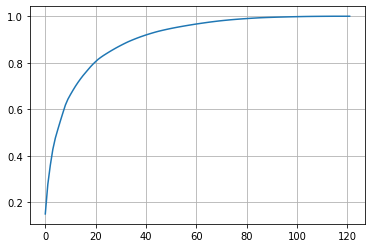

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.show()

In [ ]:
# More than 90% of variance ratio have been covered by 50 components
n_component = 50
pca_final = PCA(n_components=n_component)
x_train_pca = pca_final.fit_transform(x_train_smote)
x_train_pca.shape

(38494, 50)

In [ ]:
x_test_pca = pca_final.transform(x_test_std)
x_test_pca.shape

(9001, 50)

In [ ]:
x_train_pca.shape, x_test_pca.shape, y_train_smote.shape, y_test.shape

((38494, 50), (9001, 50), (38494,), (9001,))

In [ ]:
pickle.dump((x_train_pca, x_test_pca, y_train_smote, y_test), open('data_pca', 'wb'))

In [ ]:
lr = LogisticRegression()
lr.fit(x_train_pca, y_train_smote)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pca_pred = lr.predict(x_test_pca)

In [ ]:
metrics.confusion_matrix(y_test, y_pca_pred)

array([[6985, 1230],
       [ 148,  638]])

In [ ]:
print(metrics.classification_report(y_test, y_pca_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      8215
           1       0.34      0.81      0.48       786

    accuracy                           0.85      9001
   macro avg       0.66      0.83      0.70      9001
weighted avg       0.92      0.85      0.87      9001



In [ ]:
lr_rfe = LogisticRegression()
rfe = RFE(lr_rfe, 50)
rfe = rfe.fit(x_train_smote, y_train_smote)

In [ ]:
x_train_rfe = rfe.transform(x_train_smote)
x_test_rfe = rfe.transform(x_test_std)

x_train_rfe.shape, x_test_rfe.shape

((38494, 50), (9001, 50))

In [ ]:
lr = LogisticRegression()
lr.fit(x_train_rfe, y_train_smote)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_rfe_pred = lr.predict(x_test_rfe)

In [ ]:
metrics.confusion_matrix(y_test, y_rfe_pred)

array([[7066, 1149],
       [ 147,  639]])

In [ ]:
print(metrics.classification_report(y_test, y_rfe_pred))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      8215
           1       0.36      0.81      0.50       786

    accuracy                           0.86      9001
   macro avg       0.67      0.84      0.71      9001
weighted avg       0.93      0.86      0.88      9001



In [ ]:
pickle.dump((x_train_rfe, x_test_rfe, y_train_smote, y_test), open('data_rfe', 'wb'))

# Saved Data

In [ ]:
# 29/03/2021

In [ ]:
x_train, x_test, y_train, y_test = pickle.load(open('data_rfe', 'rb'))
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((38494, 50), (9001, 50), (38494,), (9001,))

In [ ]:
def hp_tune(clf, params,
            x_train=x_train, y_train=y_train,
            method='grid_search',
            logscale=False):
    """docs"""
    if method == 'grid_search':
        gs_clf = GridSearchCV(clf, params, scoring='f1_micro',
                              return_train_score=True)
        result = gs_clf.fit(x_train, y_train)
    elif method == 'random_search':
        rs_clf = RandomizedSearchCV(clf, params, scoring='f1_micro',
                                    return_train_score=True, verbose=1)
        result = rs_clf.fit(x_train, y_train)

    training_details(params, result, logscale)

    return result

In [ ]:
def training_details(params, result, logscale):
    ""
    print('Best Score: {}'.format(result.best_score_))
    print('Best Parameters: {}\n'.format(result.best_params_))
    
    n_param = len(params)

    if n_param == 1:
        p1 = list(params.keys())[0]
        plt.figure(figsize=(10, 5))

        if logscale:
            h_params = np.log10(params[p1])
        else:
            h_params = params[p1]

        # plot for train data
        # plot line
        plt.plot(h_params, result.cv_results_['mean_train_score'],
                 label='Train')
        # scatter plot
        sns.scatterplot(h_params, result.cv_results_['mean_train_score'])
        # annotate
        for i, score in enumerate(result.cv_results_['mean_train_score']):
            plt.annotate((params[p1][i], np.round(score, 3)), (h_params[i], score))
        # plot for test data
        # plot line
        plt.plot(h_params, result.cv_results_['mean_test_score'],
                 label='Test')
        # scatter plot
        sns.scatterplot(h_params, result.cv_results_['mean_test_score'])
        # annotate
        for i, score in enumerate(result.cv_results_['mean_test_score']):
            plt.annotate((params[p1][i], np.round(score, 3)), (h_params[i], score))
        # set grid 'on'
        plt.grid(); plt.show()

    elif n_param == 2:
        keys = list(params.keys())
        p1, p2 = keys[0], keys[1]

        train_scores = result.cv_results_['mean_train_score'].reshape(
            len(params[p1]), len(params[p2]))
        test_scores = result.cv_results_['mean_test_score'].reshape(
            len(params[p1]), len(params[p2]))
        
        fig, (train, test) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
        sns.heatmap(train_scores, annot=True, fmt='.4f', cmap='Blues',
                    xticklabels=params[p2], yticklabels=params[p1], ax=train)
        train.set(title='Train Heatmap',
                  xlabel=p2, ylabel=p1)
        
        sns.heatmap(test_scores, annot=True, fmt='.4f', cmap='Greens',
                    xticklabels=params[p2], yticklabels=params[p1], ax=test)
        test.set(title='Test Heatmap',
                  xlabel=p2, ylabel=p1)
        plt.show()

In [ ]:
def test_details(clf,
                 xtrain=x_train, y_train=y_train,
                 x_test=x_test, y_test=y_test):
    ""
    clf.fit(xtrain, y_train)
    train_pred = clf.predict(x_train)
    test_pred = clf.predict(x_test)

    print('Train f1-score:', np.round(
        metrics.f1_score(y_train, train_pred, average='micro'), 3))
    print('Test f1-score:', np.round(
        metrics.f1_score(y_test, test_pred, average='micro'), 3))

    print('\nClassification Report:')
    print(metrics.classification_report(y_test, test_pred))
    print()

    fig, (train, test) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    sns.heatmap(metrics.confusion_matrix(y_train, train_pred),
                annot=True, fmt='d', cmap='Blues', ax=train)
    
    sns.heatmap(metrics.confusion_matrix(y_test, test_pred),
                annot=True, fmt='d', cmap='Greens', ax=test)
    
    train.set(title='Train Confusion Matrix',
              xlabel='Predicted', ylabel='Actual')
    test.set(title='Test Confusion Matrix',
              xlabel='Predicted', ylabel='Actual')
    
    plt.show()

Best Score: 0.854470989558388
Best Parameters: {'C': 1000}



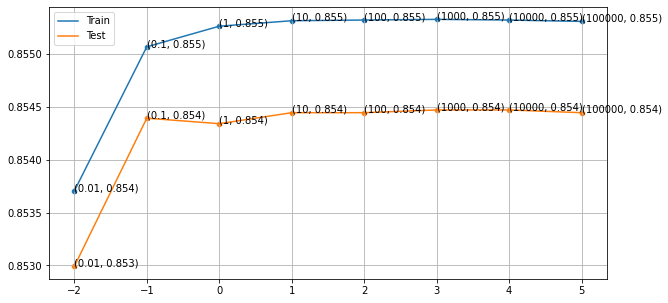

In [ ]:
# Logistic Regression

model_lr = LogisticRegression()
param_lr = {'C': [10**x for x in range(-2, 5+1)]}

r = hp_tune(model_lr, param_lr,
            x_train, y_train, logscale=True)

Train f1-score: 0.855
Test f1-score: 0.856

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      8215
           1       0.36      0.81      0.50       786

    accuracy                           0.86      9001
   macro avg       0.67      0.84      0.71      9001
weighted avg       0.93      0.86      0.88      9001




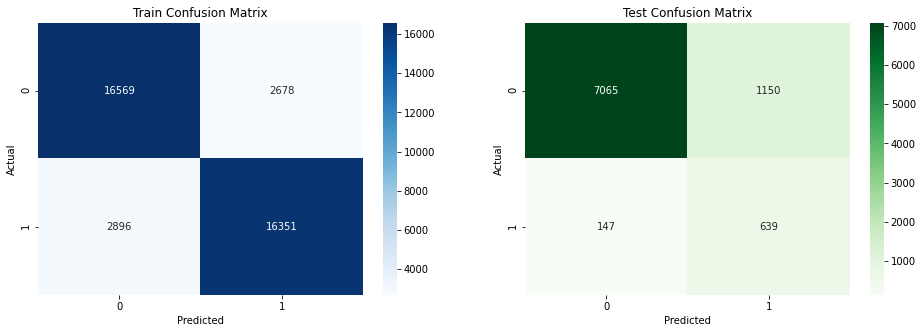

In [ ]:
# Tuned model
lr_test = LogisticRegression(penalty='l2', C=100)
test_details(lr_test, x_train, y_train, x_test, y_test)

Best Score: 0.8538734924933313
Best Parameters: {'C': 1}



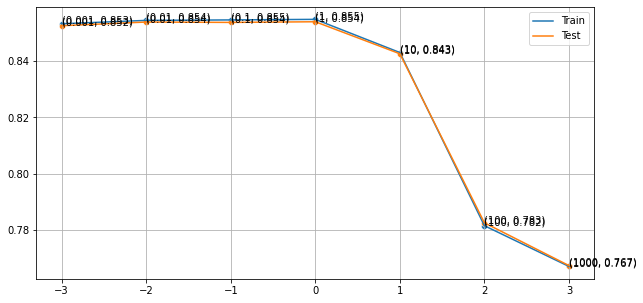

In [ ]:
# Linear SVM
p_svm = {'C': [10**x for x in range(-3, 4)]}
svm = LinearSVC()

r = hp_tune(svm, p_svm, x_train, y_train, logscale=True)

Train f1-score: 0.854
Test f1-score: 0.856

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      8215
           1       0.36      0.81      0.50       786

    accuracy                           0.86      9001
   macro avg       0.67      0.83      0.71      9001
weighted avg       0.92      0.86      0.88      9001




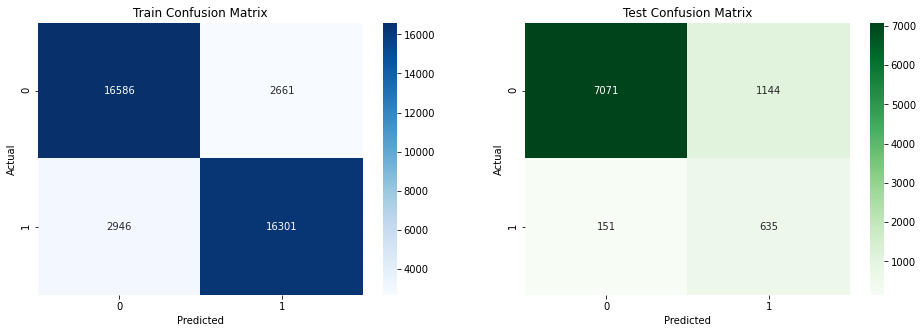

In [ ]:
test_details(LinearSVC(C=1), x_train, y_train, x_test, y_test)

Best Score: 0.9097782772583592
Best Parameters: {'max_depth': 14, 'min_samples_split': 4}



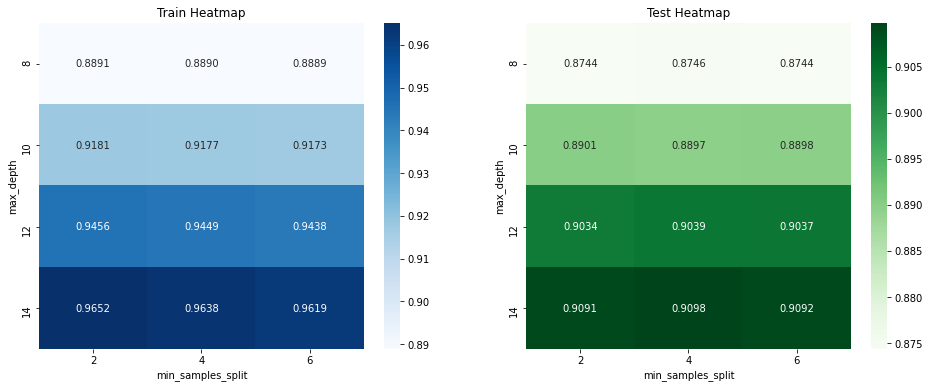

In [ ]:
dt_param = {'max_depth': [8, 10, 12, 14],
            'min_samples_split': [2, 4, 6]}
dt = DecisionTreeClassifier()

r_dt = hp_tune(dt, dt_param)

Best Score: 0.9124800314347459
Best Parameters: {'max_depth': 16, 'min_samples_leaf': 1}



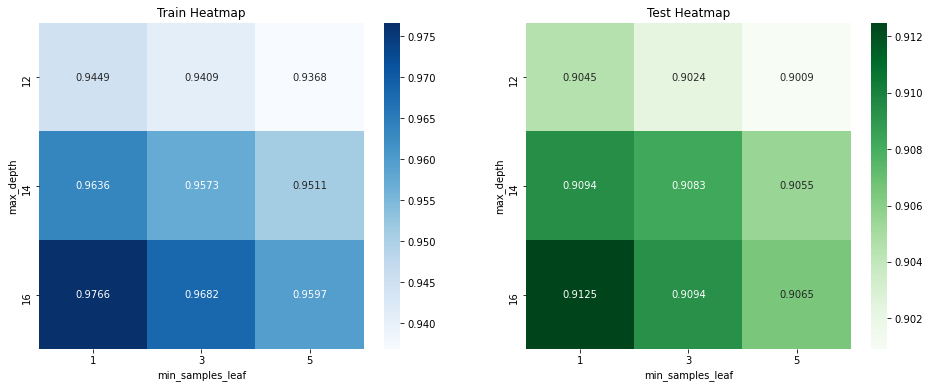

In [ ]:
dt_params = {'max_depth': [12, 14, 16],
             'min_samples_leaf': [1, 3, 5]}

dt = DecisionTreeClassifier(min_samples_split=4)

r_dt = hp_tune(dt, dt_params)

Best Score: 0.914350525694763
Best Parameters: {'max_depth': 20}



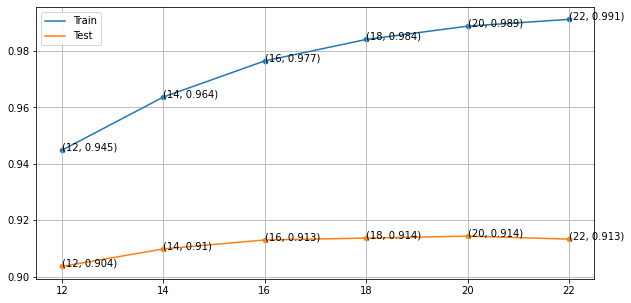

In [ ]:
dt_params = {'max_depth': [12, 14, 16, 18, 20, 22]}

dt = DecisionTreeClassifier(min_samples_split=4, min_samples_leaf=1)

r_dt = hp_tune(dt, dt_params)

Train f1-score: 0.962
Test f1-score: 0.873

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93      8215
           1       0.37      0.66      0.47       786

    accuracy                           0.87      9001
   macro avg       0.67      0.78      0.70      9001
weighted avg       0.91      0.87      0.89      9001




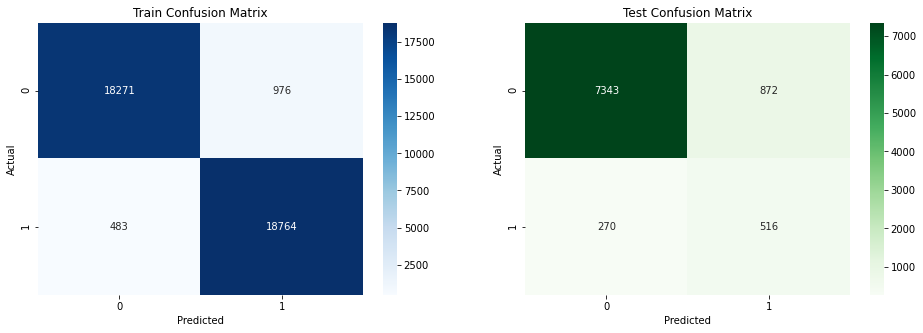

In [ ]:
# Final DT
dt_test = DecisionTreeClassifier(max_depth=14, min_samples_split=4, min_samples_leaf=1)

test_details(dt_test)

In [ ]:
rf_params = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(2,10),
    'min_samples_split': randint(2,12),
    'min_samples_leaf': randint(1,6),
}
rf = RandomForestClassifier()

r_rf = hp_tune(rf, rf_params, method='random_search')

Best Score: 0.893853736441294
Best Parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 241}



Train f1-score: 0.903
Test f1-score: 0.905

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      8215
           1       0.47      0.72      0.57       786

    accuracy                           0.91      9001
   macro avg       0.72      0.82      0.76      9001
weighted avg       0.93      0.91      0.91      9001




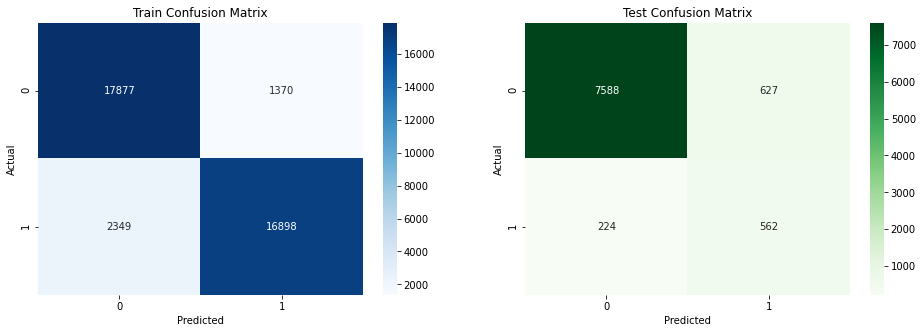

In [ ]:
# Final
test_rf = r_rf.best_estimator_

test_details(test_rf)

In [ ]:
xgb_params = {
    'n_estimators': randint(100, 400),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.3, 0.9),
    'max_depth': randint(2, 20),
    'colsample_bytree': uniform(0.5, 0.9),
    'min_child_weight': [1, 2, 3, 4]
}
xgb_clf = xgb.XGBClassifier()

r_xgb = hp_tune(xgb_clf, xgb_params, method='random_search')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 22.7min finished


Best Score: 0.9648261790366568
Best Parameters: {'colsample_bytree': 0.7665549294083001, 'learning_rate': 0.035450632940474396, 'max_depth': 17, 'min_child_weight': 3, 'n_estimators': 315, 'subsample': 0.6613436165250743}



Train f1-score: 0.998
Test f1-score: 0.935

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      8215
           1       0.65      0.57      0.61       786

    accuracy                           0.94      9001
   macro avg       0.80      0.77      0.79      9001
weighted avg       0.93      0.94      0.93      9001




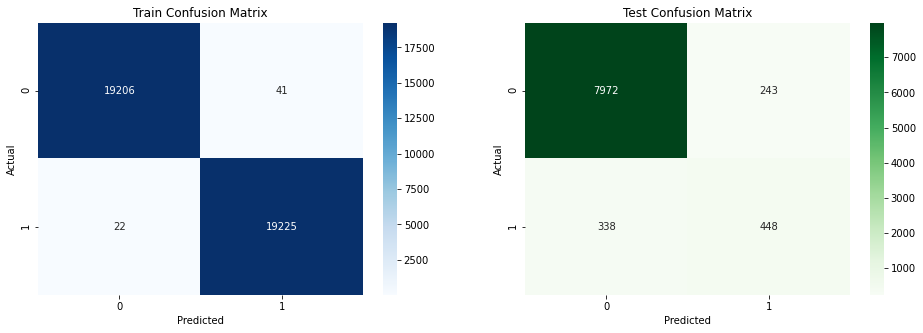

In [ ]:
best_params = {
    'colsample_bytree': 0.7665549294083001, 
    'learning_rate': 0.035450632940474396, 
    'max_depth': 17, 
    'min_child_weight': 3, 
    'n_estimators': 315, 
    'subsample': 0.6613436165250743}

test_xgb = xgb.XGBClassifier(**best_params)

test_details(test_xgb)

Best Score: 0.9101940067662049
Best Parameters: {'n_estimator': 100}



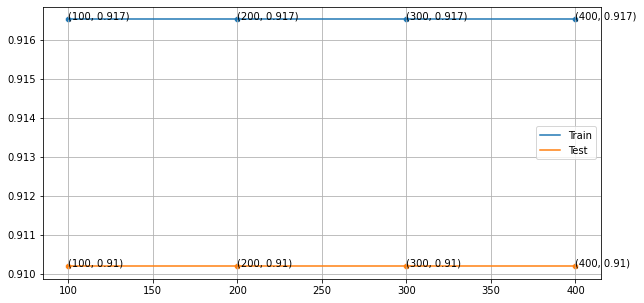

In [ ]:
param = {'n_estimator': [100, 200, 300, 400]}
clf = xgb.XGBClassifier()
r = hp_tune(clf, param)

Best Score: 0.9655274810888546
Best Parameters: {'max_depth': 14}



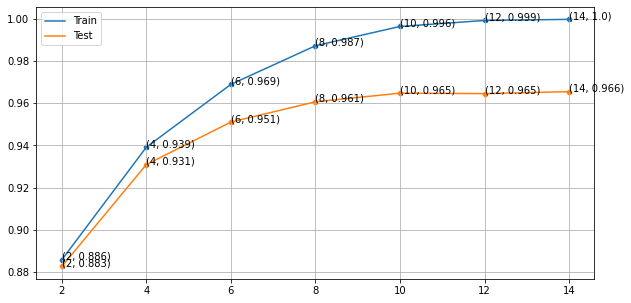

In [ ]:
param = {'max_depth': np.arange(2, 15, 2)}
clf = xgb.XGBClassifier()
r = hp_tune(clf, param)

In [ ]:
params = {
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]
}

clf = xgb.XGBClassifier(n_estimators=100, max_depth=10)

r = hp_tune(clf, params, method='random_search')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 15.8min finished


Best Score: 0.9639169228045696
Best Parameters: {'subsample': 0.8, 'min_child_weight': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6}



Train f1-score: 0.991
Test f1-score: 0.934

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      8215
           1       0.63      0.59      0.61       786

    accuracy                           0.93      9001
   macro avg       0.80      0.78      0.79      9001
weighted avg       0.93      0.93      0.93      9001




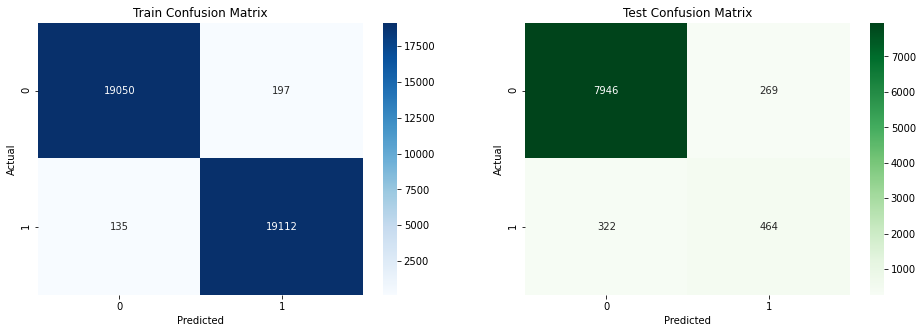

In [ ]:
params = {
    'n_estimator': 100,
    'max_depth': 10,
    'subsample': 0.8,
    'min_child_weight': 2, 
    'learning_rate': 0.1, 
    'colsample_bytree': 0.6
}

clf = xgb.XGBClassifier(**params)

test_details(clf)